# DLiP TP6 : Generative modelling

Théo Di Piazza (theo.dipiazza@gmail.com)

# Generative modelling in deep learning

Generative modelling in machine learning can aim at achieving different goals.

The first, obvious one is that a generative model can be used to generate more data, to be used afterwards by another algorithm. While a generative model cannot create more information to solve the issue of having too small datasets, it could be used to solve anonymity questions. Typically, sharing a generative model trained on private data could allow the exploitation of the statistical property of this data without sharing the data itself (which can be protected by privacy matters for example).

Another goal is to use generative modelling to better understand the data at hand. This is based on the hypothesis that a model that successfully learned to generate (and generalize) a dataset should have internally learned some efficient and compressed representation of the information contained in the data. In this case, analysing a posteriori the learned representation may give us insights on the data itself.

The notion of a generative model however needs to be more formally specified, in order to work with. What does it mean for the model to generate data that "looks like" the original dataset? A mathematical formulation of that is necessary, in order to define a training objective that can be used efficiently. Having some expert rate the quality of all generated datapoints one by one is definitely not an option.

Thus, modelling our data and models as probability distributions comes to the rescue. If we consider our data as coming from some underlying probability distribution, that we will name $p_D$, our goal is thus to train our model to represent another probability distribution, which we will name $p_\theta$, that should be some good approximation of $p_D$. Given that we only know $p_D$ through some set of realisations from it (the dataset), we can never hope to learn it exactly.

**Q1: Can you name some metrics that can be used to compare two given distributions $p_D$ and $p_\theta$?**

> **Answer Q1:** Here are 4 metrics that can be used to compare two given distributions $p_D$ and $p_\theta$ :

1. **Kullback-Leibler divergence** is a "measure of dissimilarity between 2 definitions" (source : https://fr.wikipedia.org/wiki/Divergence_de_Kullback-Leibler) which is defined by :

$$D_{KL}(p_\theta || p_D) = \sum_{i} p_\theta(i) log(\frac{p_\theta(i)}{p_D(i)}) \mbox{ or } D_{KL}(p_\theta || p_D) = \int_{-\infty}^{\infty} p_\theta(x) log(\frac{p_\theta(x)}{p_D(x)}) \, \mathrm{d}x$$

2. **Jensen–Shannon divergence** is a "symmetrized and smoothed version of the KL divergence" (source : https://en.wikipedia.org/wiki/Jensen%E2%80%93Shannon_divergence). It is defined by :    
$$D_{JS}(p_\theta || p_D) = \frac{1}{2} D_{KL}(p_\theta || \frac{p_\theta + p_D}{2}) + \frac{1}{2} D_{KL}(p_D || \frac{p_\theta + p_D}{2})$$

3. **Earth mover's distance** is a "is a measure of the distance between two probability distributions over a region D" (source : https://en.wikipedia.org/wiki/Earth_mover%27s_distance). It is defined by :
$$EMD(P, Q) = \underset{\gamma \in \Pi (p_\theta, p_D)}{\inf} \mathop{\mathbb{E}}_{(x,y) \sim \gamma} [||x-y||]$$

  Where $\Pi (p_\theta, p_D)$ is the set of all joint distributions whose marginals are $p_\theta$ and $p_D$.

4. **Mean Square Error** which simply measures the average squared differences between values of $p_\theta$ and $p_D$.

Most comparison methods can be separated into two kinds: those that compare the density of the distributions ($p_\theta(x)$ vs $p_D(x)$), and those that compare the values sampled from them. These two kinds of approaches have different behavior and trade-offs.

**Q2: Given we want to use them as an optimisation objective, what are the caveats to keep in mind about these two kinds?**

> **Answer Q2:** In the case of comparing two distributions, it may happen that the distribution is very hard to model or even interact with, which can make the calculation of the method very difficult. A solution can be to use the samples from this distribution, provided that you have enough samples to work with quality data and not lose accuracy.

In this work, we will focus on two of the most widely used generative models based on deep neural networks: Generative Adversarial Networks (GANs) and Variational AutoEncoders (VAEs), in order to compare them and understand their strengths and weaknesses.

### Generative Adversarial Networks

GANs structure is based on modelling the distribution $p_\theta$ as a learned deterministic function applied to a standard noise. Sampling from it is thus done as follows: first, some noise is sampled from a standard N-dimensional Gaussian distribution: $\epsilon \sim \mathcal{N}(0;I)$, and then the output is computed as a deterministic function $x = f_\theta(\epsilon)$. The function $f_\theta$ is implemented as a neural network, $\theta$ representing its learned parameters.

**Q3: What is, a priori, the impact of the choice of N, the dimension of the input noise $\epsilon$?**

> **Answer Q3:** A priori, N will have an impact on the quality of the representations learned by the model. In the case where N is too small, there is a risk that the model will not be able to generate useful and different information for each sample. Increasing N is a way to have a "more expressive" model as it will be able to capture more variables. However, there is a risk of overlearning and having too much complexity.

By construction, this generator structure only allows sampling the distribution $p_\theta$, and does not allow the computation of the density $p_\theta(x)$ (at least not without strong assumptions on $f_\theta$). Such a model thus needs a comparison method based on samples to be trained.

The smart idea of GANs is to instead use another neural network to model the objective. Another neural network is introduced: a classifier (that we call the discriminator) which is trained to distinguish examples from the dataset from examples generated by $p_\theta$. The reasoning is as follows:

The discriminator $D$ is trained using a classic classifier loss between the two classes defined as the samples generated by either $p_D$ or $p_\theta$. This way $D(x)$ can be interpreted as the probability that $x$ came from the real dataset:

$$ \mathcal{L}_D = \mathbb{E}_{p_D} \left[ -\log D(x) \right] + \mathbb{E}_{p_\theta} \left[ -\log \left(1-D(x)\right) \right] $$

From that, it can be shown that for the generator fixed, the optimal discriminator is given by $D(x) = \frac{p_D(x)}{p_\theta(x) + p_D(x)}$, and when reached its loss takes a specific value:

$$ \mathcal{L}_D = 2 \left( \log 2 - JSD(p_\theta \| p_D) \right) $$
, where JSD is the JS divergence used to measure the similarity of two distributions. 
$$JSD(p_\theta \| p_D) = \frac{1}{2} \mathbb{E}_{p_D} \left[ log(\frac{2p_D}{p_D+p_\theta}) \right] + \frac{1}{2} \mathbb{E}_{p_\theta} \left[ log(\frac{2p_\theta}{p_D+p_\theta}) \right]$$
So, training the generator network to *maximize* the same loss would, assuming the discriminator is always trained to optimality, minimize the Jensen-Shannon Divergence between $p_\theta$ and $p_D$, and thus bring $p_\theta$ closer to $p_D$.

**Q4: Can you anticipate a caveat of using the JSD as a training objective for the generator?**

> **Answer Q4:** If the descriminator works perfectly, i.e. if it is trained to optimality and all samples: this will lead to a vanishing gradient problem since it will perfectly predicts the class of each sample. There is therefore a risk that the JSD criterion does not provide information on the learning quality of the generator.

Having the generator trained to maximize $\mathcal{L}_D$ is equivalent to setting its training loss to $ \mathcal{L}_G = \mathbb{E}_{p_\theta} \log(1-D(x)) $.

**Q5: This loss only gives feedback to the generator on samples it generated, what problem may this cause?**

> **Answer Q5:** When the generator only receives feedback on the samples it generates and the descriminator is bad, there is a risk that the generator will not learn correctly because the feedback is always positive. In addition, there is a risk that the generator is only good at generating certain classes correctly at the expense of other classes which represent the whole distribution; because loss would encourage generating only those classes on which the generator works well.

We will now work on implementing a GAN on a simple toy problem, to get a feeling of its behavior and test our theoretical insights. For this we will use the `pytorch` library.

While a real problem would be generating images for example (each datapoint $x$ would then be a different image), this is a kind of task that easily requires intensive CPU/GPU power, and image datasets are difficult to visualize from a geometric point of view (even small images contains hundreds of pixels, and nobody can visualize points in a 100-dimensional space). So instead we will focus on points in the plane: each datapoint $x$ will actually be a couple of numbers $(x1, x2)$, and our target dataset will be a 2D two-moons shape with some noise.

In [1]:
import time
import torch
import math
from sklearn import datasets
import numpy as np

# Our dataset is mathematically defined, we can generate batches on the fly and enjoy
# an infinite-size dataset
def generate_batch(batchlen):
    """This function generates a batch of length 'batchlen' from the dataset
    """
    data = datasets.make_moons(n_samples=batchlen, noise=0.05)[0].astype(np.float32)
    return torch.from_numpy(data)

Let's plot a large batch, to see what the dataset looks like.

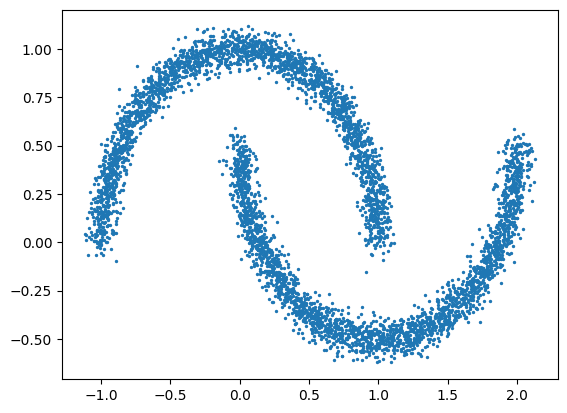

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt

batch = generate_batch(5000)

plt.scatter(batch[:,0], batch[:,1], s=2.0)
plt.show()

We now need to define our two neural networks, the generator and the discriminator. The generator will take as input a value $z$ sampled from a Gaussian prior, and output a value $x$ (thus a couple $(x_1,x_2)$). The discriminator takes as input a value $x$, and is a binary classifier.

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

# Choose a value for the prior dimension
PRIOR_N = 2

# Define the generator
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(PRIOR_N, 2)
        
    def __call__(self, z):
        return self.fc1(z)
    
    def generate(self, batchlen):
        z = torch.normal(torch.zeros(batchlen, PRIOR_N), 1.0)
        return self.__call__(z)
    

# Define the discriminator
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(2, 1)
    
    def __call__(self, x):
        return self.fc1(x)

With these classes in shape, now is only needed the training loop. To stick with the mathematical GAN framework, we should train the discriminator until convergence between each training step of the generator. This is not practical for two reasons: first it takes a lot of time, and second if the discriminator is too good, it will generate vanishing gradients to the generator (as seen in **Q4**).

We will thus train the discriminator a fixed number of times between each training iteration of the generator.

In [ ]:
# improvement of the baseline
import torch.nn as nn
import torch.nn.functional as F

# Choose a value for the prior dimension
PRIOR_N = 2

# Define the generator
class Generator(nn.Module):
    def __init__(self, depth, width):
        '''
        depth : number of layers between input and last layer
        width : dimension per layer
        '''
        super().__init__()
        self.depth = depth # depth of the network
        self.width = width # width of the network
        # first layer
        self.modules = [nn.Linear(PRIOR_N, width)]
        self.modules.append(torch.nn.ReLU())
        # hidden layer
        for i in range(self.depth):
          self.modules.append(nn.Linear(width, width))
          self.modules.append(torch.nn.ReLU())
        # classification layer
        self.modules.append(nn.Linear(width, 2))
        self.sequential = nn.Sequential(*self.modules)

    def __call__(self, z):
        return self.sequential(z)
    
    def generate(self, batchlen):
        z = torch.normal(torch.zeros(batchlen, PRIOR_N), 1.0)
        return self.__call__(z)
    

# Define the discriminator
class Discriminator(nn.Module):
    def __init__(self, depth, width):
        super().__init__()
        self.depth = depth # depth of the network
        self.width = width # width of the network
        # first layer
        self.modules = [nn.Linear(PRIOR_N, width)]
        self.modules.append(torch.nn.ReLU())
        # hidden layer
        for i in range(self.depth):
          self.modules.append(nn.Linear(width, width))
          self.modules.append(torch.nn.ReLU())
        # classification layer
        self.modules.append(nn.Linear(width, 1))
        self.sequential = nn.Sequential(*self.modules)
    
    def __call__(self, x):
        return self.sequential(x)

step 0: discriminator: 1.353e+00, generator: 5.858e-01


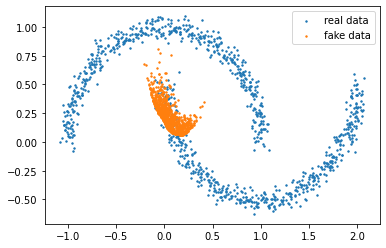

step 1000: discriminator: 1.386e+00, generator: 7.127e-01


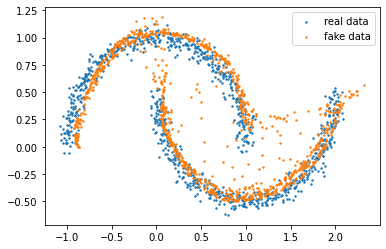

step 2000: discriminator: 1.388e+00, generator: 7.049e-01


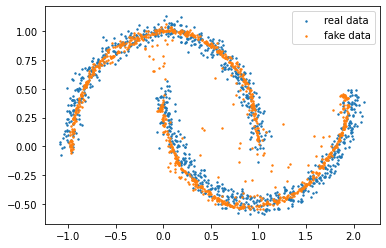

step 3000: discriminator: 1.389e+00, generator: 7.032e-01


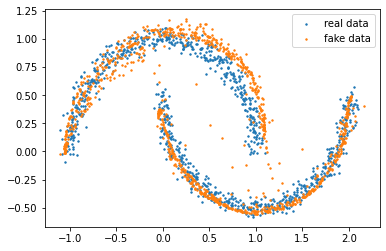

step 4000: discriminator: 1.383e+00, generator: 6.959e-01


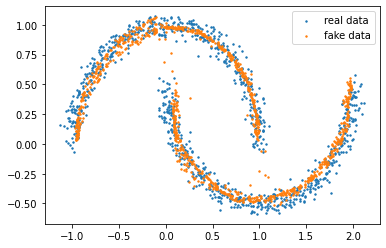

step 5000: discriminator: 1.389e+00, generator: 6.933e-01


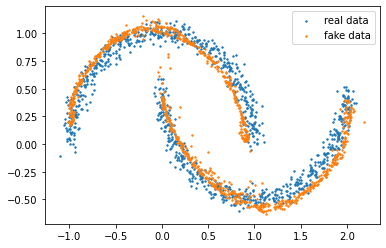

step 6000: discriminator: 1.388e+00, generator: 6.958e-01


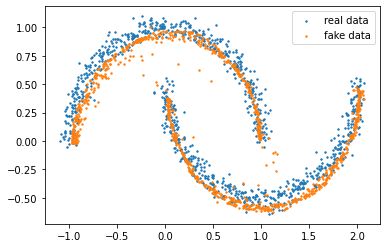

step 7000: discriminator: 1.379e+00, generator: 6.943e-01


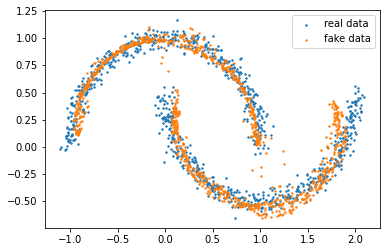

step 8000: discriminator: 1.392e+00, generator: 6.929e-01


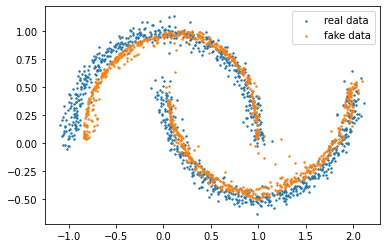

step 9000: discriminator: 1.380e+00, generator: 6.932e-01


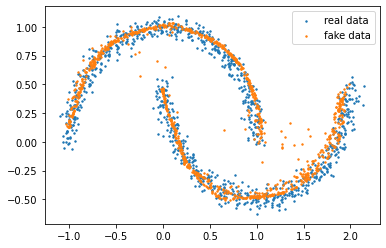

step 10000: discriminator: 1.388e+00, generator: 6.966e-01


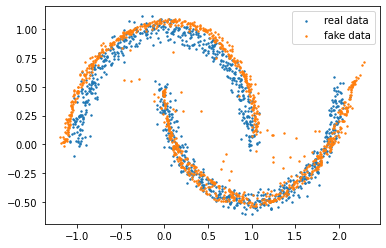

step 11000: discriminator: 1.387e+00, generator: 7.031e-01


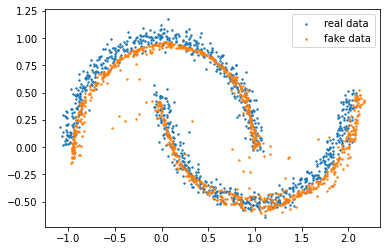

step 12000: discriminator: 1.383e+00, generator: 6.963e-01


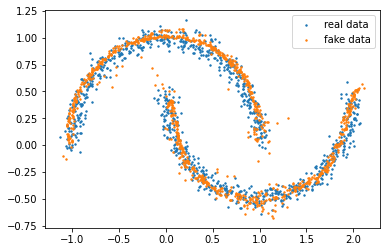

step 13000: discriminator: 1.357e+00, generator: 7.144e-01


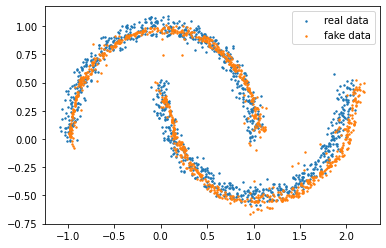

step 14000: discriminator: 1.363e+00, generator: 7.160e-01


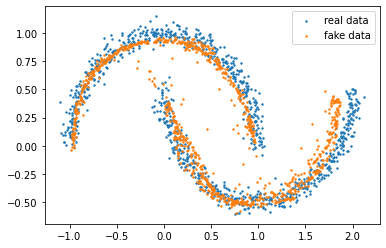

step 15000: discriminator: 1.366e+00, generator: 7.460e-01


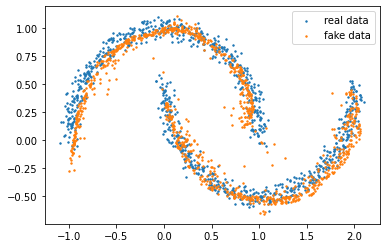

step 16000: discriminator: 1.383e+00, generator: 7.127e-01


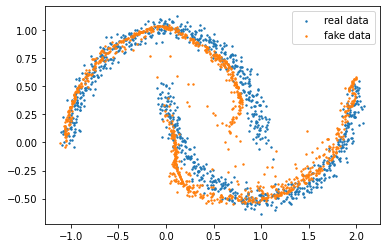

step 17000: discriminator: 1.421e+00, generator: 6.838e-01


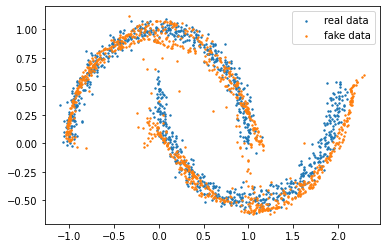

step 18000: discriminator: 1.401e+00, generator: 6.973e-01


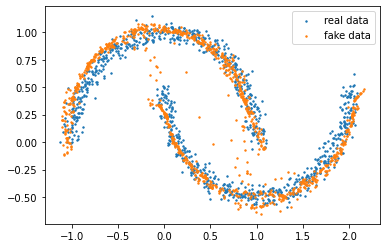

step 19000: discriminator: 1.381e+00, generator: 6.923e-01


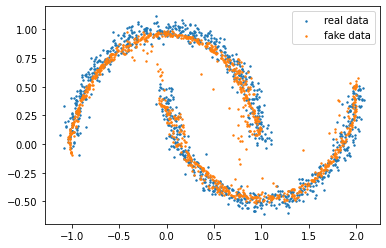

step 20000: discriminator: 1.387e+00, generator: 6.897e-01


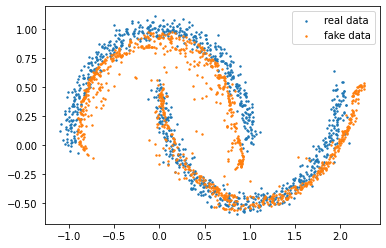


 > Execution time : 350.64s !


In [ ]:
# Number of times to train the discriminator between two generator steps
TRAIN_RATIO = 5
# Total number of training iterations for the generator
N_ITER = 20001
# Batch size to use
BATCHLEN = 128

generator = Generator(depth=1, width=128) # initialize generator
optim_gen = torch.optim.Adam(generator.parameters(), lr=0.001, betas=(0.5,0.9)) # generator optimizer

discriminator = Discriminator(depth=1, width=32) # initialize discriminator
optim_disc = torch.optim.Adam(discriminator.parameters(), lr=0.001, betas=(0.5,0.9)) # discriminator optimizer

# labels to compare prediction of discriminator to true classes
labels_real = torch.ones((BATCHLEN, 1)) # tensor of 1 : true class
labels_fake = torch.zeros((BATCHLEN, 1)) # tensor of 0 : fake class
# criterion for classification task of the discriminator BCE
criterion_disc = torch.nn.BCEWithLogitsLoss()

start_time = time.time()

for i in range(N_ITER):
    # train the discriminator
    for _ in range(TRAIN_RATIO):
        discriminator.zero_grad()
        # generate a batch from observations : true
        real_batch = generate_batch(BATCHLEN)
        # generate batch from generator : fake
        fake_batch = generator.generate(BATCHLEN)
        #
        # == COMPUTE THE DISCRIMINATOR LOSS HERE ==
        #

        # apply discriminator on true observations
        real_disc = discriminator(real_batch)
        # apply discriminator on generated observations
        fake_disc = discriminator(fake_batch)
        # compute loss for discriminator
        disc_loss = criterion_disc(real_disc, labels_real) + criterion_disc(fake_disc, labels_fake)

        disc_loss.backward()
        optim_disc.step()
    # train the generator
    generator.zero_grad()
    fake_batch = generator.generate(BATCHLEN)
    #
    # == COMPUTE THE GENERATOR LOSS HERE
    #

    # apply discriminator on generated observations
    fake_disc = discriminator(fake_batch)
    # compute the loss by comparing FAKE predictions to TRUE labels
    gen_loss = criterion_disc(fake_disc, labels_real)

    gen_loss.backward()
    optim_gen.step()
    if i%1000 == 0:
        print('step {}: discriminator: {:.3e}, generator: {:.3e}'.format(i, float(disc_loss), float(gen_loss)))
        # plot the result
        real_batch = generate_batch(1024)
        fake_batch = generator.generate(1024).detach()
        plt.scatter(real_batch[:,0], real_batch[:,1], s=2.0, label='real data')
        plt.scatter(fake_batch[:,0], fake_batch[:,1], s=2.0, label='fake data')
        plt.legend()
        plt.show()

execution_time = time.time() - start_time
print(f'\n > Execution time : {execution_time:.2f}s !')

Complete the previous code and train your model.

Depending on your choice of parameters, the training may not go well at all, with the generator completely collapsing quickly at the beginning of the training. It has been observed by the litterature that the generator's loss $\mathcal{L}_G = \mathbb{E}_{p_\theta} \log(1-D(x))$ is often to blame.

**Q6: Why could we anticipate that this loss could cause this?**

> **Answer Q6:** At the beginning of the training the generator is of poor quality and it is very easy for the discriminator to classify the samples as real or fake. This implies that $D(x)=0$ for every sample and leads to a vanishing gradient problem. As suggested by the topic, a solution can be to replace the loss of the generator by $\mathcal{L}_G = \mathbb{E}_{p_\theta} [ -\log D(x) ]$.

This issue is solved by replacing the generator loss by an alternative loss: $\mathcal{L}_G = \mathbb{E}_{p_\theta} [ -\log D(x) ]$ to avoid gradient vanishing.

**Q7: Inspect the impact of these different factors:**

- depth / width of the generator network
- depth / width of the discriminator network
- impact of `TRAIN_RATIO`

> **Answer Q7:** For each parameter, different values are tested: their influence on the performance of the model and their impact on the execution times are indicated.

- **Generator depth** : [1, 2, 3, 4] hidden layers were tried with ReLU activation function. When the number of layers is too low (1), the model does not converge towards a solution. From 2 layers with ReLU, the method manages to converge and generate samples very close to the observations. When the number of layers is too high, overlearning is observed. Logically, the execution time increases with the number of layers (from 225s for 1 layer to 258 seconds for 2 layers to 445s for 4 layers for example).

- **Generator width** : [8, 16, 32, 64, 128, 256] were tried for width of hidden layer for the generator. When width is too small, the model fails to generate samples close to the observations. The execution times increase with the width of the network.

- **Discriminator depth** : [1, 2, 3] hidden layers were tried. Observations are similar with generator depth. As the number of layers increases, the noise decreases. Execution times increase with the depth of the network.

- **Discriminator width** : [8, 16, 32, 64] were tried of width of hidden layer of the discriminator. The smaller the width, the more iterations the network needs to converge to a satisfactory solution. Bias and noise decrease with increasing width.

- **Impact of `TRAIN_RATIO`** : [1, 2, 3] where tried. For 1, 2 and 3 we have good results, especially for 3. The higher the value chosen, the longer the training times.

For further readings on GANs, you can see the following papers:

- Generative Adversarial Networks *(Goodfellow et al.)*: [arXiv:1406.2661](https://arxiv.org/abs/1406.2661)
- Unsupervised Representation Learning with Deep Convolutional Generative Adversarial Networks *(Radford et al.)*: [arXiv:1511.06434](https://arxiv.org/abs/1511.06434)
- A Style-Based Generator Architecture for Generative Adversarial Networks *(Karras et al.)* [arxiv:1812.04948v3](https://arxiv.org/abs/1812.04948v3)

### Variational AutoEncoders

Another well-known approach to generative modelling is embodied by Variational AutoEncoders (VAEs). While the generative model itself and the procedure to sample it is similar to GANs, the way it is trained is not.

The main goal of VAEs is to optimize the likelihood of the real data according to the generative model. In other words, maximize $\mathbb{E}_{p_D} \left[\log p_\theta(x) \right ]$, which is equivalent to minimizing $D_{KL}(p_D \| p_\theta)$.
$$D_{KL}(p_D \| p_\theta) = \mathbb{E}_{p_D}\left[ log(\frac{p_D}{p_\theta}) \right]$$

**Q8: Prove this equivalence.**

> **Answer Q8:** 

$$D_{KL}(p_D \| p_\theta) = \mathbb{E}_{p_D}\left[ log(\frac{p_D}{p_\theta}) \right] = \mathbb{E}_{p_D}\left[ log(p_D) \right] - \mathbb{E}_{p_D}\left[ log(p_\theta) \right]$$

  And $\mathbb{E}_{p_D}\left[ log(p_D) \right]$ is independant from $\theta$ hence maximize $\mathbb{E}_{p_D} \left[\log p_\theta(x) \right ]$ is equivalent to minimize $D_{KL}(p_D \| p_\theta)$.

However, the classes of distributions for which $\log p_\theta(x)$ can be analytically computed and optimized is very restricted, and not suitable for real world problems. The main idea of the VAE is thus to introduce a latent variable $z$ and decompose the distribution as: $p_\theta(x, z) = p_\theta(x | z) p(z)$. Here $p(z)$ is some fixed prior and $p_\theta(x | z)$ is a simple distribution whose parameters are the output of a neural network.

For example, you could have $p(z)$ be a standard $\mathcal{N}(0;1)$ and $p_\theta(x | z)$ be defined as a gaussian $\mathcal{N}(\mu_\theta(z); \sigma_\theta(z))$ where $\mu_\theta(z)$ and $\sigma_\theta(z)$ are created by the neural network you will train. In this case, the resulting distribution $p_\theta(x) = \int_z p_\theta(x|z)p(z)dz$ is an infinite mixture of Gaussians, which is a much more expressive class of distributions.

Now, this cannot stop here, as we are not able to analitically compute the density $p_\theta(x)$. The second main idea of the VAE is to introduce another, auxilliary distribution: $q_\phi(z | x)$, which will be modelled by a neural network similarly to $p_\theta(x | z)$. Introducing it allows us to create a lower bound for $\log p_\theta(x)$:

$$\log p_\theta(x) = \mathbb{E}_{z \sim q_\phi} \log p_\theta(x) = \mathbb{E}_{z \sim q_\phi} \left[ \log p_\theta(x) \frac {q_\phi(z|x)}{q_\phi(z|x)} \right]$$

Following Bayes theorem, $p_\theta(x) p_\theta(z|x) = p_\theta(x, z) = p_\theta(x|z) p(z)$, so we get:

$$\log p_\theta(x) = \mathbb{E}_{z \sim q_\phi} \left[ \log \frac{p_\theta(x|z) p(z)}{p_\theta(z|x)} \frac {q_\phi(z|x)}{q_\phi(z|x)} \right]$$

Re-organizing the terms:

$$\log p_\theta(x) = \mathbb{E}_{z \sim q_\phi} \log \frac{q_\phi(z|x)}{p_\theta(z|x)} + \mathbb{E}_{z \sim q_\phi} \log \frac{p(z)}{q_\phi(z|x)} + \mathbb{E}_{z \sim q_\phi} \log p_\theta(x | z)$$

This can be re-expressed like so:

$$\log p_\theta(x) = D_{KL}(q_\phi(z | x) \| p_\theta(z | x)) - D_{KL}(q_\phi(z | x) \| p(z)) + \mathbb{E}_{z \sim q_\phi} \log p_\theta(x|z)$$

The 3 terms of this equality can be interpreted like so:

- the first term measures how much $q_\phi(z | x)$ is similar to $p_\theta(z | x)$, or in other words is a good inverse of $p_\theta(x | z)$
- the second term measures how similar $q_\phi(z|x)$ is from the latent prior $p(z)$
- the third term is linked to how likely $p_\theta$ is to yield the given $x$ when $z$ is sampled from $q_\phi(z | x)$ rather than $p(z)$

It is interesting to note that the first term, being a KL-divergence is always positive. As such the combination of the last two terms forms a lower bound of $\log p_\theta(x)$ which *can* be computed and used as a training objective. This bound is called the *Evidence Lower-Bound (ELBO)*. Simply flipping its sign can make it into a loss that can be minimized by gradient descent:

$$ \mathcal{L}_{ELBO} = D_{KL}(q_\phi(z | x) \| p(z)) + \mathbb{E}_{z \sim q_\phi} [ - \log p_\theta(x|z) ]$$

From this formulation comes the parallel with auto-encoders that give the VAE its name: $q_\phi(z | x)$ can be seen as a *probabilistic encoder* from the data $x$ to the latent space $z$, and $p_\theta(x | z)$ can be seen as a *probabilistic decoder* from the latent space $z$ to the data $x$. In this case the second term of $\mathcal{L}_{ELBO}$ is the loss measuring the reconstruction quality of the auto-encoder, and the first term can be seens as a regularization of the latent space.

![VAE](vae-gaussian.png)

**Q9: We can see that $p(z)$ is never sampled during the training process, how can that be a problem?**

> **Answer Q9:** If $p(z)$ is never sampled during training, there is a risk that the outputs generated from these samples or samples similar to $p(z)$ could be of poor quality. This could lead to a risk of over-training as the model would not be able to generalise to other priors.

A typical choice to represent $q_\phi(z | x)$ is to use a diagonal Gaussian distribution $\mathcal{N}(\mu_\phi(x); Diag(\sigma_\phi^2(x)))$, which makes the KL-divergence term of $\mathcal{L}_{ELBO}$ analytically computable.

**Q10: Assuming $p(z)$ is a $\mathcal{N}(0; Id)$ gaussian, what is the value of $D_{KL}(q_\phi(z | x) \| p(z))$?**

> **Answer Q10:** 

We have that : 

$$D_{KL}(p_D \| p_\theta) = \mathbb{E}_{p_D}\left[ log(\frac{p_D}{p_\theta}) \right]$$

With distributions of the questions, it comes that :

$$D_{KL}(q_\phi(z | x) \| p(z)) = \mathbb{E}_{p_D}\left[ log(\frac{q_\phi(z | x)}{p(z)}) \right]$$

$$= \mathbb{E}_{p_D}\left[ log \left( \frac{ \frac{1}{(2 \pi)^{\frac{d}{2}}} |Diag(\sigma_\phi^2(x))|^{-\frac{1}{2}} exp(-\frac{1}{2}[z-\mu_\phi(x)]^{T} Diag(\sigma_\phi^2(x))^{-1}[z-\mu_\phi(x)])  } {\frac{1}{(2 \pi)^{\frac{d}{2}}}exp \left(-\frac{1}{2}z^{T}Iz \right)}  \right) \right]$$

$$= \mathbb{E}_{p_D}\left[ -\frac{1}{2}log(|Diag(\sigma_\phi^2(x))|) -\frac{1}{2}[z-\mu_\phi(x)]^{T} Diag(\sigma_\phi^2(x))^{-1}[z-\mu_\phi(x)] + \frac{1}{2}z^{T}Iz \right]$$

$$= \mathbb{E}_{p_D}\left[ -\frac{1}{2}log(|Diag(\sigma_\phi^2(x))|) -\frac{1}{2}Tr([z-\mu_\phi(x)][z-\mu_\phi(x)]^{T}Diag(\sigma_\phi^2(x))^{-1}) + \frac{1}{2}Tr(Izz^{T}) \right]$$

$$= -\frac{1}{2}log(|Diag(\sigma_\phi^2(x))|)  -\frac{1}{2}Tr(\mathbb{E}_{p_D}\left[ [z-\mu_\phi(x)][z-\mu_\phi(x)]^{T}Diag(\sigma_\phi^2(x))^{-1}) \right] + \frac{1}{2}Tr(I\mathbb{E}_{p_D}\left[zz^{T}\right])$$

$$= -\frac{1}{2}log(|Diag(\sigma_\phi^2(x))|)  -\frac{1}{2}Tr(Diag(\sigma_\phi^2(x))Diag(\sigma_\phi^2(x))^{-1}) + \frac{1}{2} (Tr(Diag(\sigma_\phi^2(x))) + \mu_\phi(x)^{T}\mu_\phi(x))$$

$$⟹ D_{KL}(q_\phi(z | x) \| p(z)) = \frac{1}{2}\sum_{i=1}^{N}( \sigma_{\phi, i}^2(x) + \mu_{\phi, i}^2(x) - log(\sigma_{\phi, i}^2(x)) - 1 )$$

We will also model $p_\theta(x | z)$ as a diagonal Gaussian $\mathcal{N}(\mu_\theta(z); Diag(\sigma_\theta^2(z)))$.


**Note:** For the following, be careful about the difference between $\mu_\phi, \sigma_\phi$ which define the Gaussian distribution of the *encoder* $q_\phi$ and $\mu_\theta, \sigma_\theta$ which define the Gaussian distribution of the *decoder* $p_\theta$.

**Q11: What is the expression of $-\log p_\theta(x | z)$ for given $x$ and $z$?**

> **Answer Q11:** $p_\theta(x | z)$ as a diagonal Gaussian $\mathcal{N}(\mu_\theta(z); Diag(\sigma_\theta^2(z)))$ hence it comes that its density distribution is :

$$ p_\theta(x | z) = \frac{1}{(2\pi)^{\frac{d}{2}}} |Diag(\sigma_\theta^2(z))|^{-\frac{1}{2}} exp(-\frac{1}{2}[x-\mu_\theta(z)]^{T} Diag(\sigma_\theta^2(z))^{-1}[x-\mu_\theta(z)])$$

By applying $log$, it comes that :

$$log(p_\theta(x | z)) = -\frac{d}{2}log(2\pi) - \frac{1}{2}log(|Diag(\sigma_\theta^2(z))|) - \frac{1}{2}[x-\mu_\theta(z)]^{T} Diag(\sigma_\theta^2(z))^{-1}[x-\mu_\theta(z)]$$

$$⟹ -log(p_\theta(x | z)) = \frac{1}{2} (d log(2\pi) + log(|Diag(\sigma_\theta^2(z))|) + [x-\mu_\theta(z)]^{T} Diag(\sigma_\theta^2(z))^{-1}[x-\mu_\theta(z)]$$

We will build and train a VAE using the same dataset as previously, in order to compare its behavior to GANs. For numerical stability, we will interpret the output of the encoder and decoder networks as $(\mu, \log\sigma^2)$, rather than $(\mu, \sigma)$.

In [ ]:
# Choose a value for the latent dimension
LATENT_N = 10

# Define the generator
class Encoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc_mu = nn.Linear(2, LATENT_N)
        self.fc_logvar = nn.Linear(2, LATENT_N)
        
    # encode a datapoint. This should return a couple of tensors (mu, logvar) representing
    # the parameters of the Gaussian q_\phi(z | x)
    def __call__(self, x):
        '''
        inputs:
          x : dimension [batch_size, 2]
        outputs:
          mu : dimension [batch_size, LATENT_N]
          logvar : dimension [batch_size, LATENT_N] 
        '''
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        return (mu, logvar)
    

# Define the discriminator
class Decoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc_mu = nn.Linear(LATENT_N, 2)
        self.fc_logvar = nn.Linear(LATENT_N, 2)
    
    # decode a datapoint. This should return a couple of tensors (mu, logvar) representing
    # the parameters of the Gaussian p_\theta(z | x)
    def __call__(self, z):
        mu = self.fc_mu(z)
        logvar = self.fc_logvar(z)
        return (mu, logvar)

    def generate(self, batchlen):
        z = torch.normal(torch.zeros(batchlen, LATENT_N), 1.0)
        (mu, logvar) = self.__call__(z)
        return torch.normal(mu, torch.exp(0.5*logvar))

In [ ]:
## Improvement of the baseline

# Implementation of hardencoding and deeper architecture

# Choose a value for the latent dimension
LATENT_N = 10

# Define the generator
class Encoder(nn.Module):
    def __init__(self, depth, width):
        '''
        depth : number of layers between input and last layer
        width : dimension per layer
        '''
        super().__init__()
        self.depth = depth # depth of the network
        self.width = width # width of the network
        # first layer
        self.modules = [nn.Linear(2, width)]
        self.modules.append(torch.nn.ReLU())
        # hidden layer
        for i in range(self.depth):
          self.modules.append(nn.Linear(width, width))
          self.modules.append(torch.nn.ReLU())
        self.sequential = nn.Sequential(*self.modules)
        # layer for mu and logvar
        self.fc_mu = nn.Linear(width, LATENT_N)
        self.fc_logvar = nn.Linear(width, LATENT_N)
        
    # encode a datapoint. This should return a couple of tensors (mu, logvar) representing
    # the parameters of the Gaussian q_\phi(z | x)
    def __call__(self, x):
        '''
        inputs:
          x : dimension [batch_size, 2]
        outputs:
          mu : dimension [batch_size, LATENT_N]
          logvar : dimension [batch_size, LATENT_N] 
        '''
        # apply hidden layers
        x = self.sequential(x)
        # apply mu and logvar layer
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        return (mu, logvar)
    

# Define the discriminator
class Decoder(nn.Module):
    def __init__(self, depth, width, flag_hardcoding=False, std=0.0001):
        super().__init__()
        '''
        depth : number of layers between input and last layer
        width : dimension per layer
        '''
        super().__init__()
        self.depth = depth # depth of the network
        self.width = width # width of the network
        self.flag_hardcoding = flag_hardcoding # true if hardcoding, false otherwise
        self.std = 0.0001 # value of std for hardcoding
        # first layer
        self.modules = [nn.Linear(LATENT_N, width)]
        self.modules.append(torch.nn.ReLU())
        # hidden layer
        for i in range(self.depth):
          self.modules.append(nn.Linear(width, width))
          self.modules.append(torch.nn.ReLU())
        self.sequential = nn.Sequential(*self.modules)
        # layer for mu and logvar
        self.fc_mu = nn.Linear(width, 2)
        if(not self.flag_hardcoding):
          self.fc_logvar = nn.Linear(width, 2)
    
    # decode a datapoint. This should return a couple of tensors (mu, logvar) representing
    # the parameters of the Gaussian p_\theta(z | x)
    def __call__(self, z):
        '''
        inputs:
          z : dimension [batch_size, LATENT_N]
        outputs:
          mu : dimension [batch_size, 2]
          logvar : dimension [batch_size, 2] 
        '''
        # apply hidden layers
        z = self.sequential(z)
        # apply mu and logvar layer
        mu = self.fc_mu(z)
        # hardencoding if needed
        if(self.flag_hardcoding):
          logvar = np.log(self.std)*torch.ones_like(mu)
        # else prediction by the decoder
        else:
          logvar = self.fc_logvar(z)
        return (mu, logvar)

    def generate(self, batchlen):
        z = torch.normal(torch.zeros(batchlen, LATENT_N), 1.0)
        (mu, logvar) = self.__call__(z)
        return torch.normal(mu, torch.exp(0.5*logvar))

From this, the parameters of both networks are trained conjointly using the same loss $\mathcal{L}_{ELBO}$. 

step 0: KL: 1.218e-01, rec: 2.595e+00


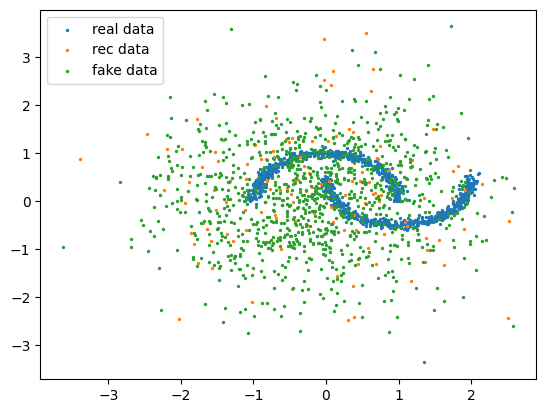

step 1000: KL: 5.412e-01, rec: 1.328e+00


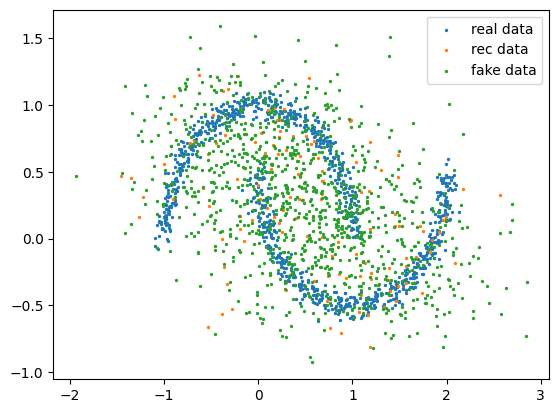

step 2000: KL: 1.219e+00, rec: 3.497e-01


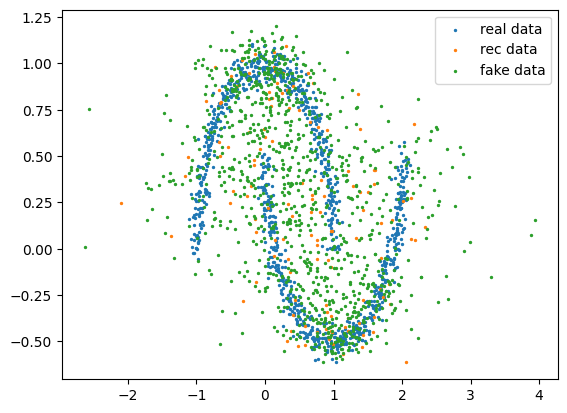

step 3000: KL: 1.351e+00, rec: 1.994e-01


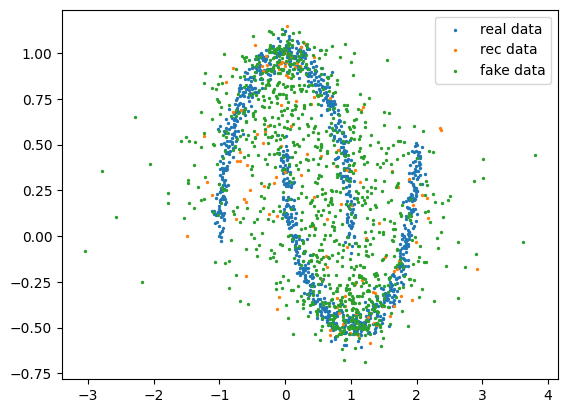

step 4000: KL: 1.367e+00, rec: 8.442e-02


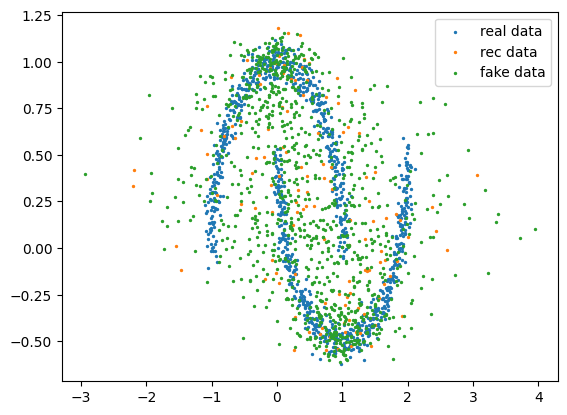

step 5000: KL: 1.407e+00, rec: 1.515e-01


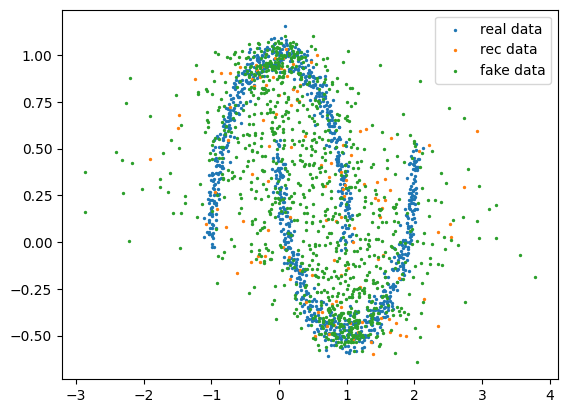

step 6000: KL: 1.470e+00, rec: 2.622e-02


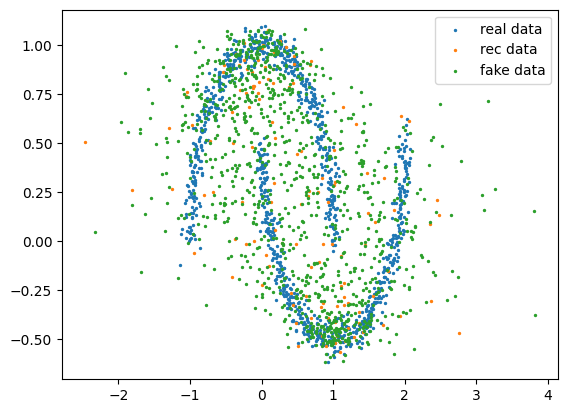

step 7000: KL: 1.483e+00, rec: 4.557e-02


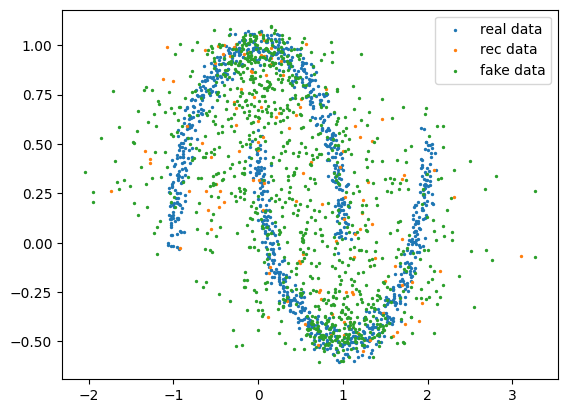

step 8000: KL: 1.446e+00, rec: 1.124e-01


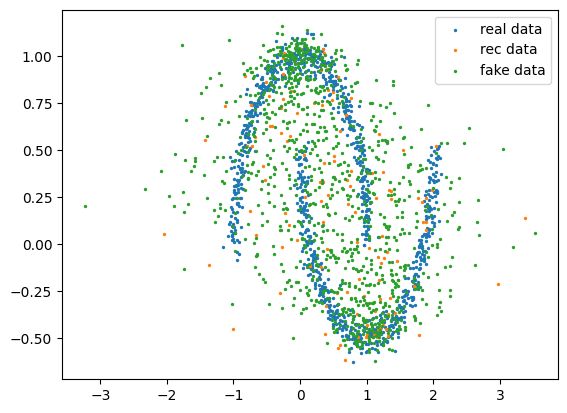

step 9000: KL: 1.498e+00, rec: 9.965e-02


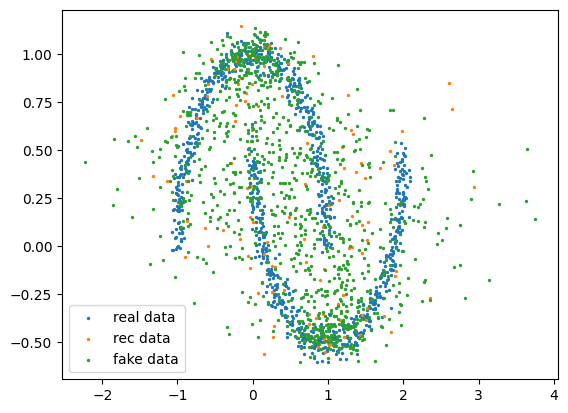

step 10000: KL: 1.520e+00, rec: -1.178e-01


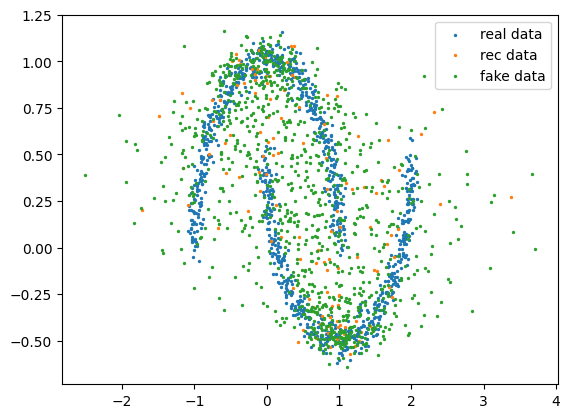

step 11000: KL: 1.490e+00, rec: -9.077e-02


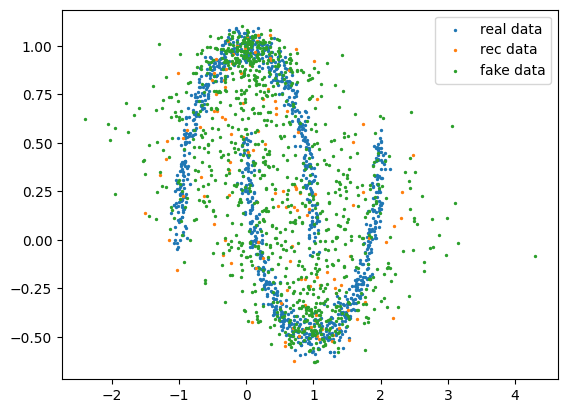

step 12000: KL: 1.531e+00, rec: -7.801e-02


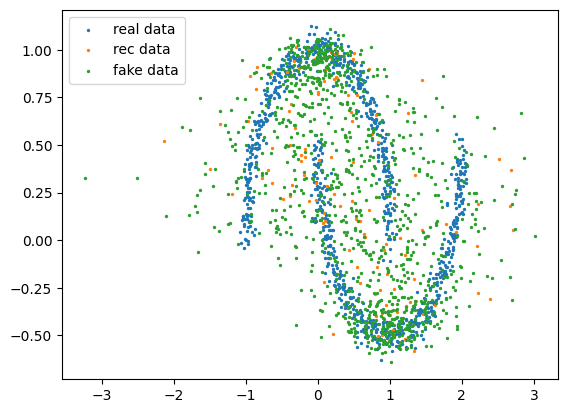

step 13000: KL: 1.539e+00, rec: -3.972e-02


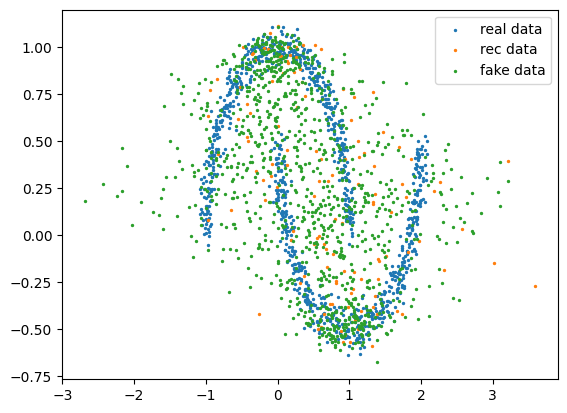

step 14000: KL: 1.557e+00, rec: -2.250e-01


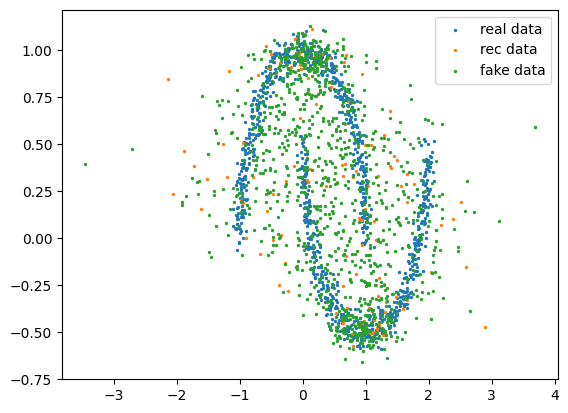

step 15000: KL: 1.573e+00, rec: -1.998e-01


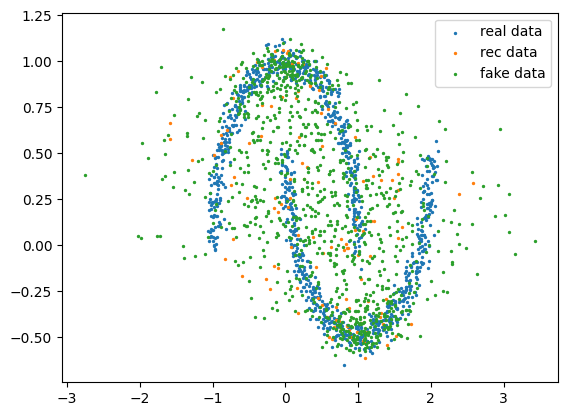

step 16000: KL: 1.593e+00, rec: -1.001e-01


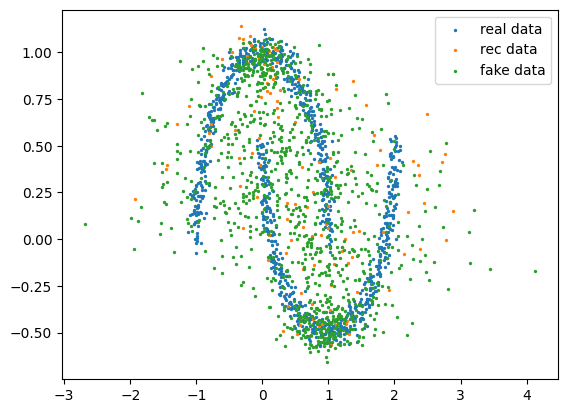

step 17000: KL: 1.591e+00, rec: -3.731e-02


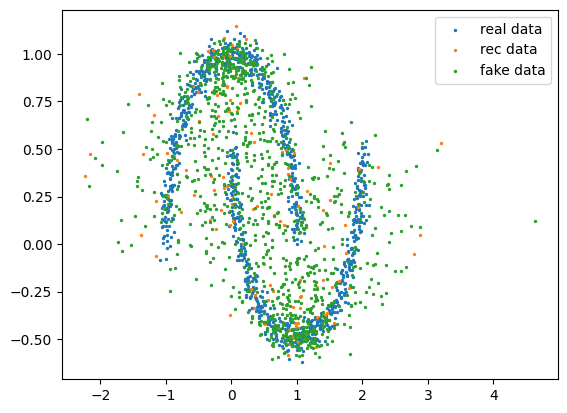

step 18000: KL: 1.601e+00, rec: -1.756e-01


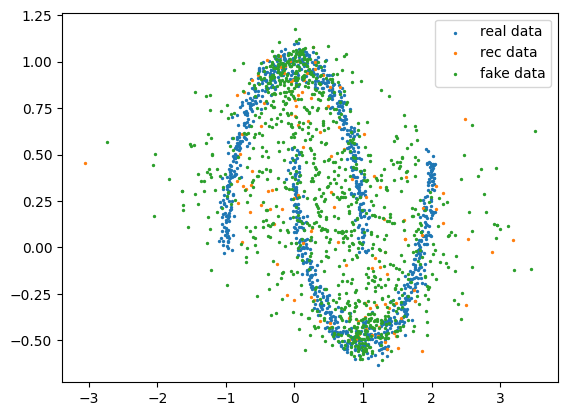

step 19000: KL: 1.615e+00, rec: -1.292e-01


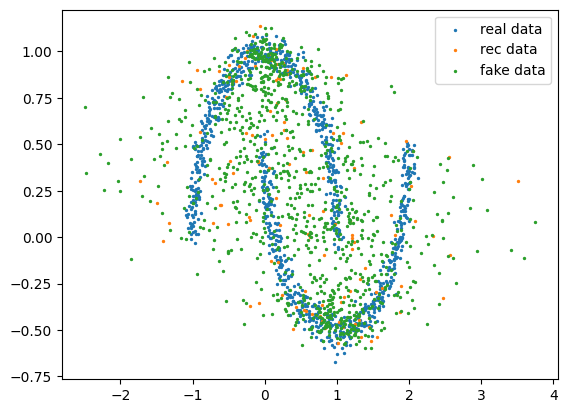

step 20000: KL: 1.635e+00, rec: -2.781e-01


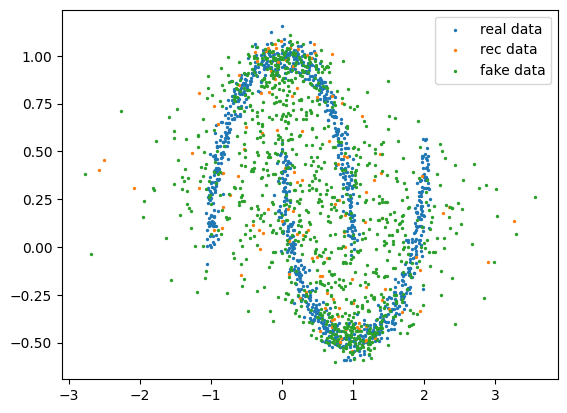

step 21000: KL: 1.633e+00, rec: -1.302e-01


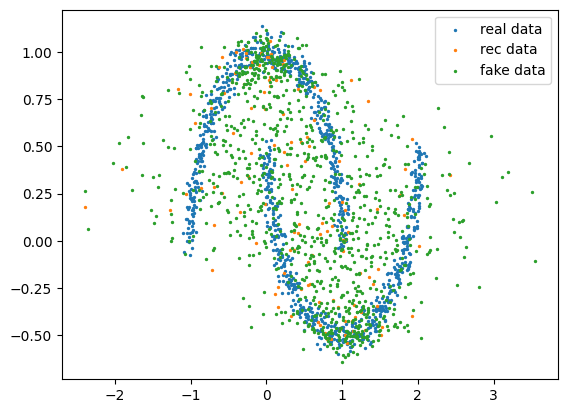

step 22000: KL: 1.615e+00, rec: -2.022e-01


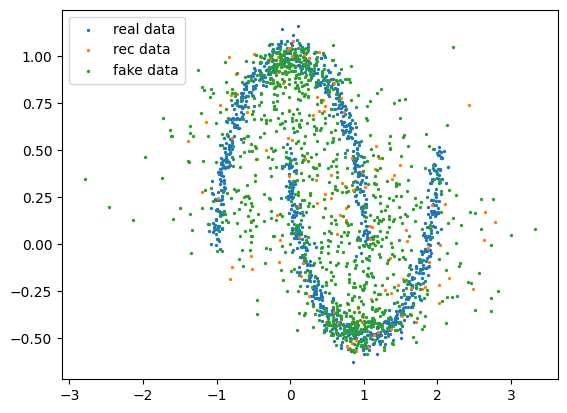

step 23000: KL: 1.667e+00, rec: -1.611e-01


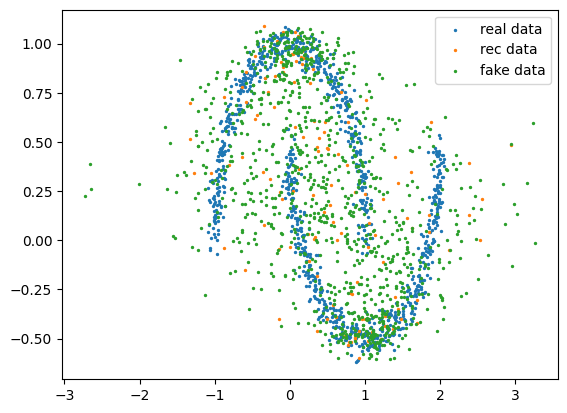

step 24000: KL: 1.630e+00, rec: -1.909e-01


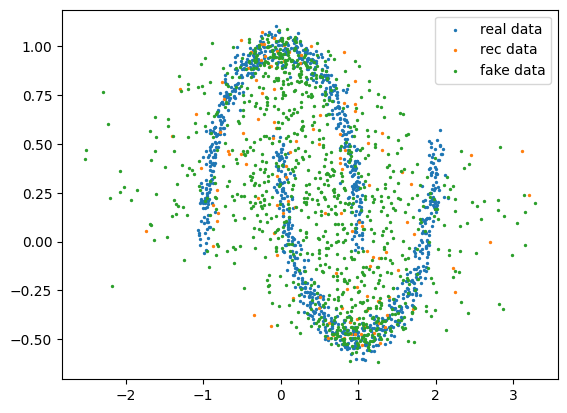

step 25000: KL: 1.606e+00, rec: -1.639e-01


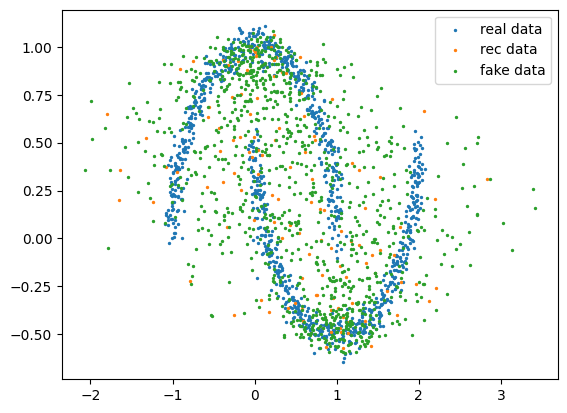

step 26000: KL: 1.618e+00, rec: -1.803e-01


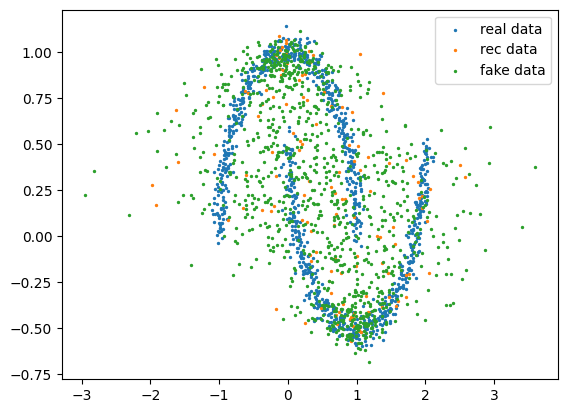

step 27000: KL: 1.645e+00, rec: -1.377e-01


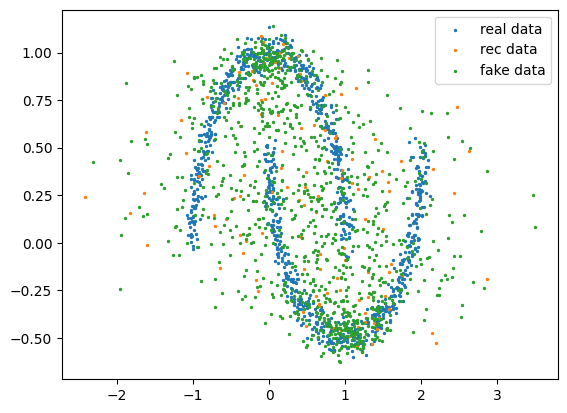

step 28000: KL: 1.683e+00, rec: -2.223e-01


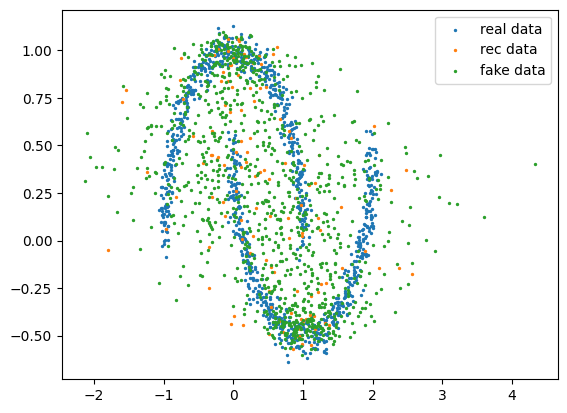

step 29000: KL: 1.683e+00, rec: -3.280e-02


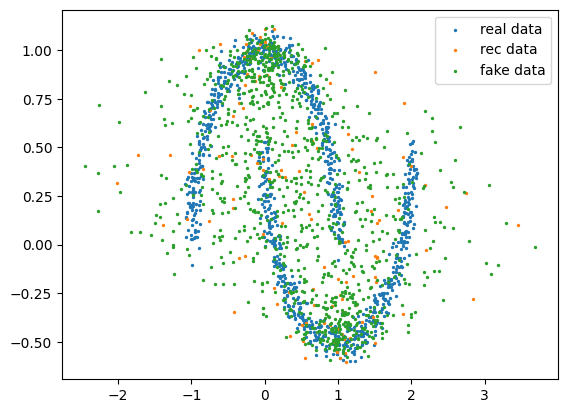

step 30000: KL: 1.675e+00, rec: -1.460e-01


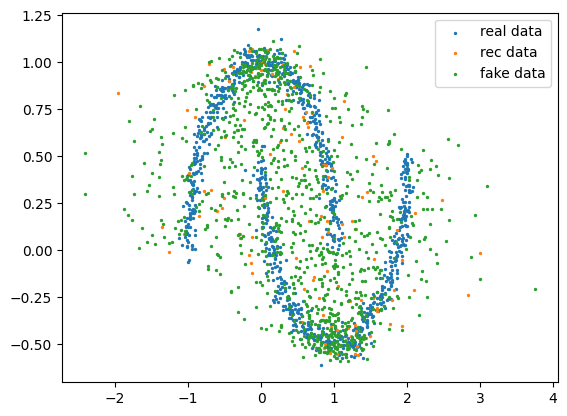

step 31000: KL: 1.676e+00, rec: -1.585e-01


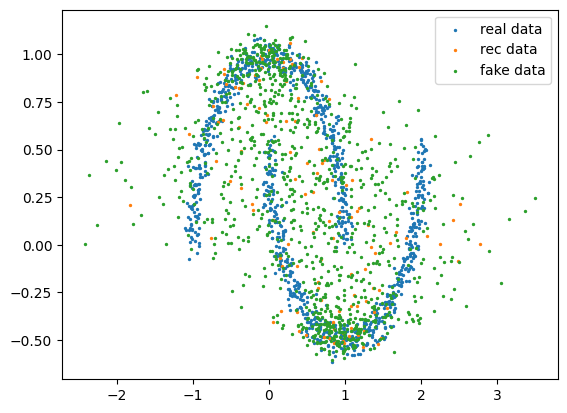

step 32000: KL: 1.673e+00, rec: -2.479e-01


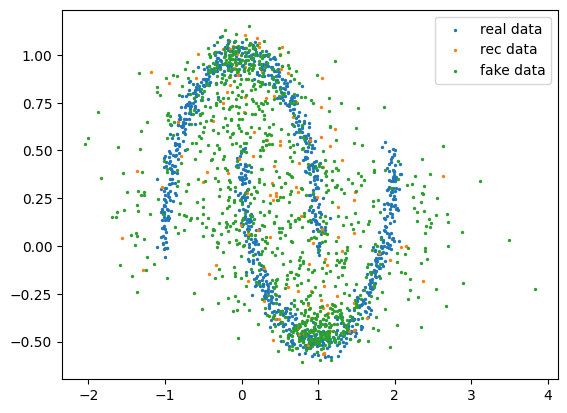

step 33000: KL: 1.660e+00, rec: -1.362e-01


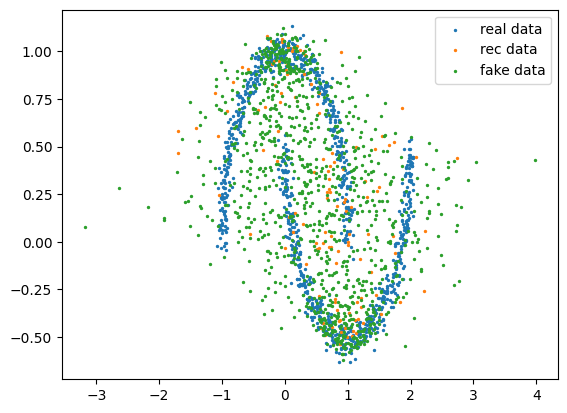

step 34000: KL: 1.713e+00, rec: -4.223e-01


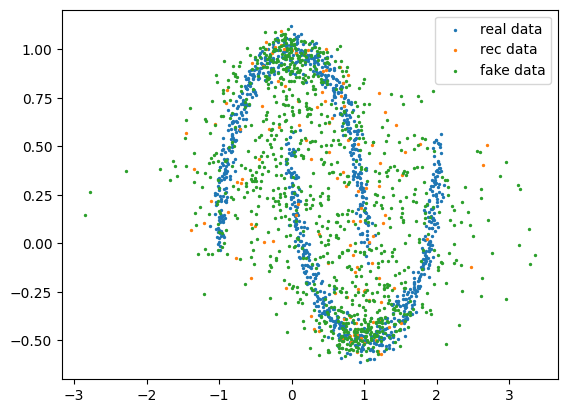

step 35000: KL: 1.699e+00, rec: -1.007e-01


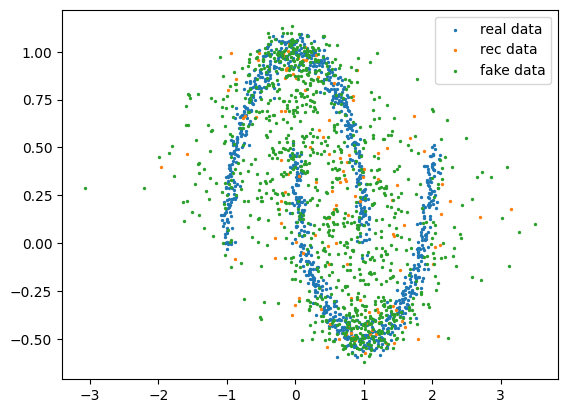

step 36000: KL: 1.698e+00, rec: -2.205e-01


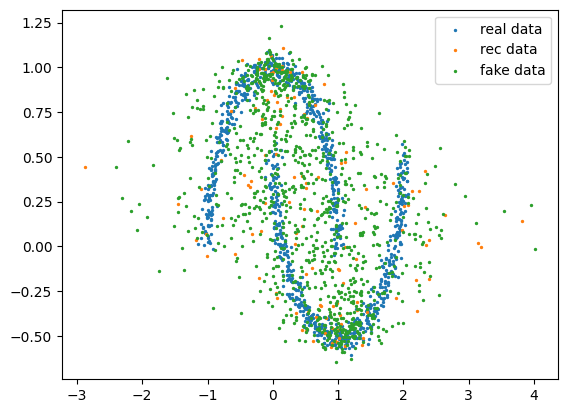

step 37000: KL: 1.685e+00, rec: -2.202e-01


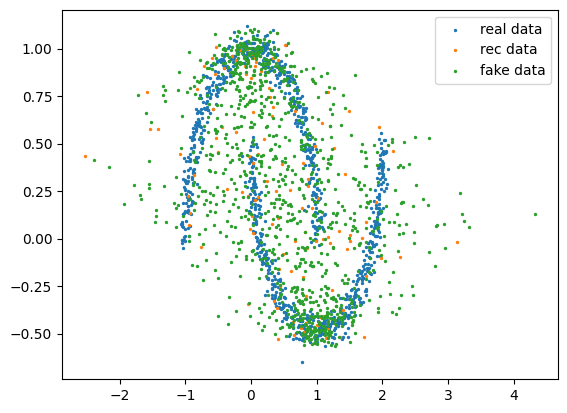

step 38000: KL: 1.681e+00, rec: -2.271e-01


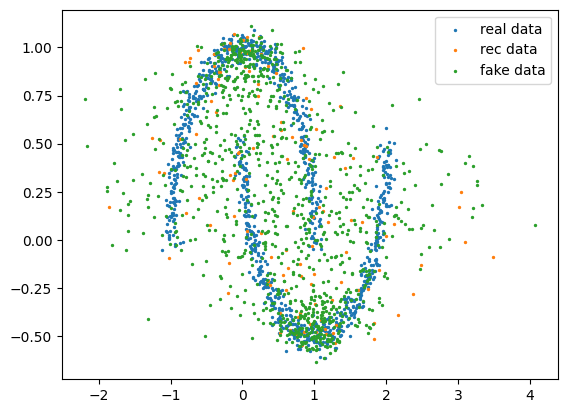

step 39000: KL: 1.667e+00, rec: -2.979e-01


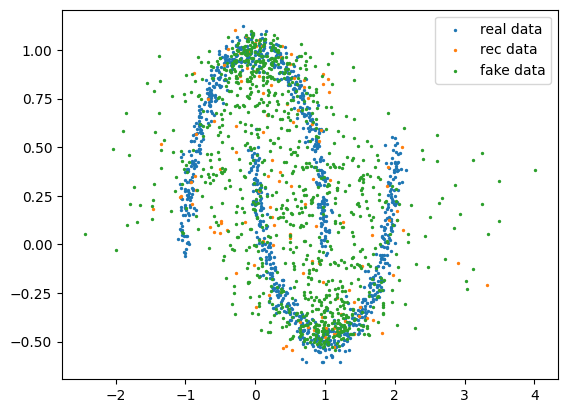

step 40000: KL: 1.714e+00, rec: -3.909e-01


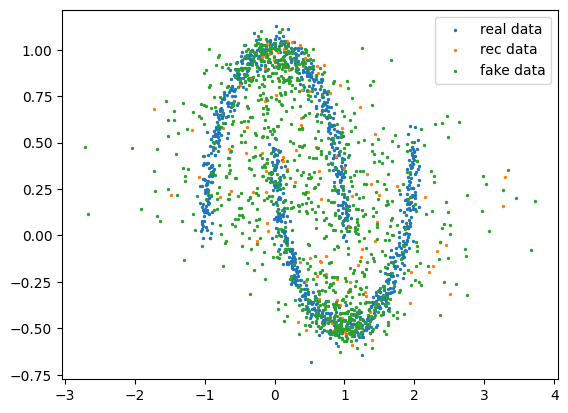

In [ ]:
# Total number of training iterations for the VAE
N_ITER = 40001
# Batch size to use
BATCHLEN = 128

# depth and with of encoder and decoder
depth_encoder, width_encoder = 2, 30
depth_decoder, width_decoder = 2, 30
# flag_hardcoding : true for hardencoding, false otherwise
flag_hardcoding = False

encoder = Encoder(depth_encoder, width_encoder)
optim_enc = torch.optim.Adam(encoder.parameters(), lr=0.001, betas=(0.5,0.9))
decoder = Decoder(depth_decoder, width_decoder, flag_hardcoding)
optim_dec = torch.optim.Adam(decoder.parameters(), lr=0.001, betas=(0.5,0.9))

start_time = time.time()

for i in range(N_ITER):
    encoder.zero_grad()
    decoder.zero_grad()
    
    x = generate_batch(BATCHLEN)
    
    enc_mu, enc_logvar = encoder(x)
    #
    # COMPUTE THE KL PART OF THE LOSS HERE
    #
    # It corresponds to the formula of Question 10
    # Sum over axis=1 since dimensions are [batch size, 10]
    # Then average losses over batches (over axis 0)
    loss_kl = - LATENT_N/2 + torch.sum(enc_mu**2 + torch.exp(enc_logvar) - enc_logvar, axis=1) / 2
    loss_kl = loss_kl.mean()

    #
    # SAMPLE z FROM q(z|x) HERE
    #
    eps_z = torch.randn((BATCHLEN, LATENT_N))
    z = enc_mu + eps_z*torch.exp(enc_logvar/2) 
    
    dec_mu, dec_logvar = decoder(z)
    #
    # COMPUTE THE RECONSTRUCTION PART OF THE LOSS HERE
    #
    # Start by computing log_p from question 11 
    loss_rec = torch.mean( ( dec_mu.shape[1]*np.log(2*np.pi) + torch.sum(dec_logvar + ((x - dec_mu)**2) * torch.exp(-dec_logvar), dim=1) )/2 )
    
    (loss_kl + loss_rec).backward()
    optim_enc.step()
    optim_dec.step()
    if i%1000 == 0:
        print('step {}: KL: {:.3e}, rec: {:.3e}'.format(i, float(loss_kl), float(loss_rec)))
        # plot the result
        real_batch = generate_batch(1024)
        rec_batch = torch.normal(dec_mu, torch.exp(0.5*dec_logvar)).detach()
        fake_batch = decoder.generate(1024).detach()
        plt.scatter(real_batch[:,0], real_batch[:,1], s=2.0, label='real data')
        plt.scatter(rec_batch[:,0], rec_batch[:,1], s=2.0, label='rec data')
        plt.scatter(fake_batch[:,0], fake_batch[:,1], s=2.0, label='fake data')
        plt.legend()
        plt.show()

execution_time = time.time() - start_time
print(f'Execution time : {execution_time:.2f}s !')

**Q12: Try hardcoding $\sigma_\theta(z)$ to some small value (like 1E-4) rather than allowing the decoder to learn it. What does it change?**

> **Answer Q12:** 

*(Implementation results of Q12 is below)*

For this question, a **flag_hardcoding** variable is added to the above model to force the prediction of the standard deviation to 1e-4.

  It can be seen that the results are more satisfactory than before because the reconstruction converges more quickly to the true observations. In other words, there is less noise and scatter for the reconstructed points (in green above). In some ways, the reconstructed data are better and more homogeneously distributed around the two moons as opposed to before when the reconstructed points were almost all reconstructed in the same place ("in the hollow of the moons"). After several runs with different values for the standard deviation, it can be seen that if the standard deviation is too low (e.g. 1e-8), then the reconstruction is not at all satisfactory. Hardcoding is a good alternative to learning to decode, but care must be taken with the value chosen.

step 0: KL: 2.652e-02, rec: 6.428e+03


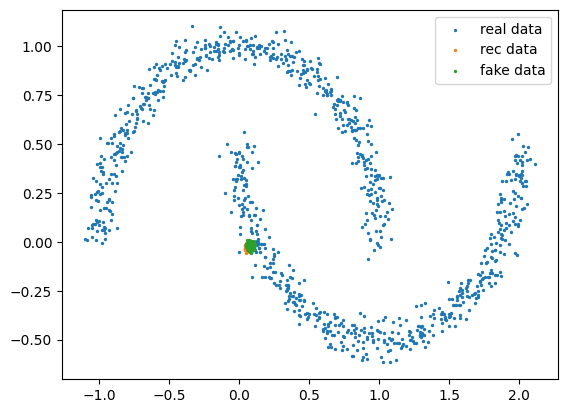

step 1000: KL: 1.715e+01, rec: 4.783e+01


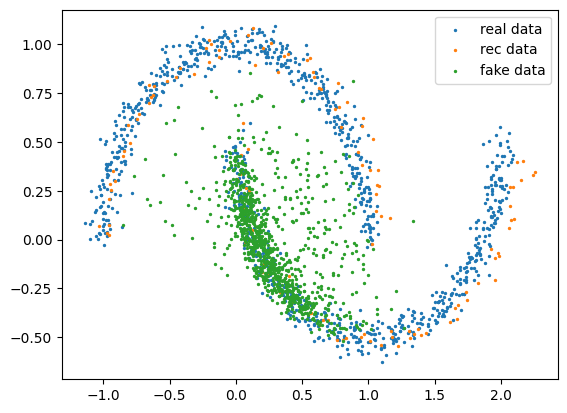

step 2000: KL: 1.061e+01, rec: 5.101e-01


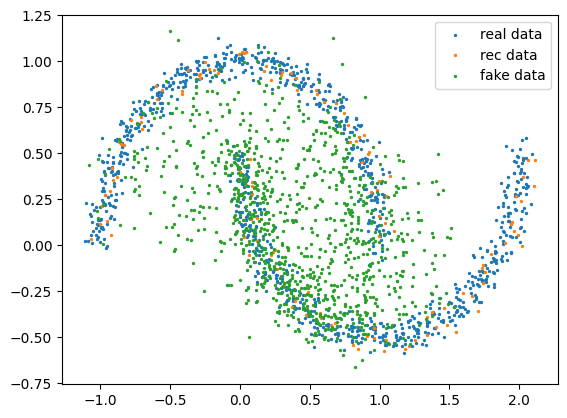

step 3000: KL: 8.995e+00, rec: -8.926e-01


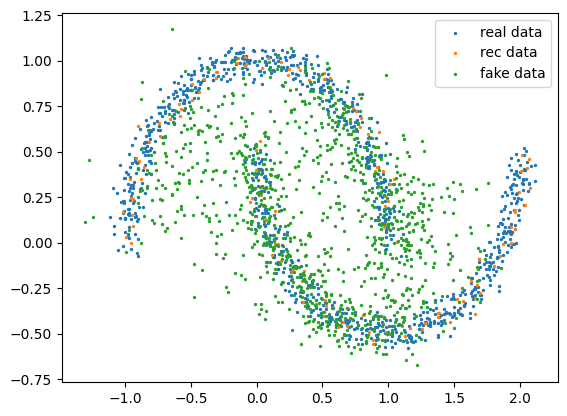

step 4000: KL: 8.280e+00, rec: -1.846e+00


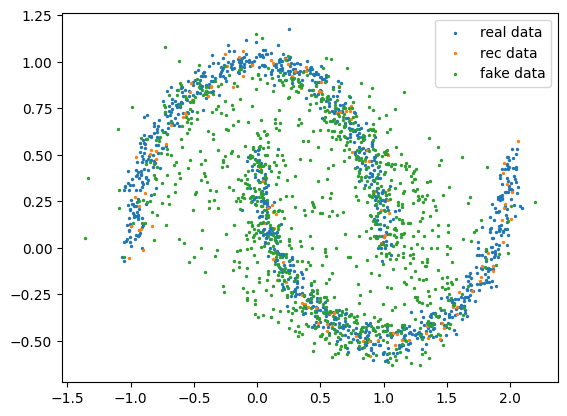

step 5000: KL: 7.897e+00, rec: 2.378e+00


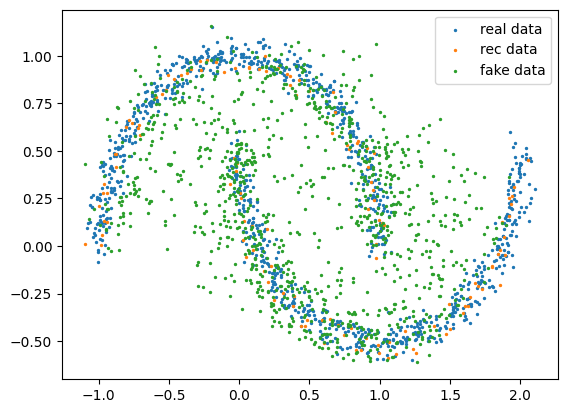

step 6000: KL: 7.833e+00, rec: -3.381e+00


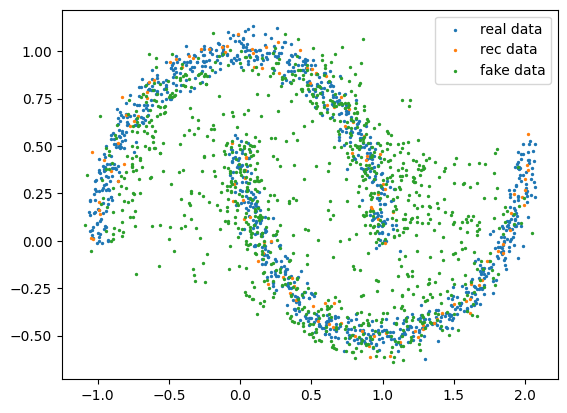

step 7000: KL: 7.759e+00, rec: -2.809e+00


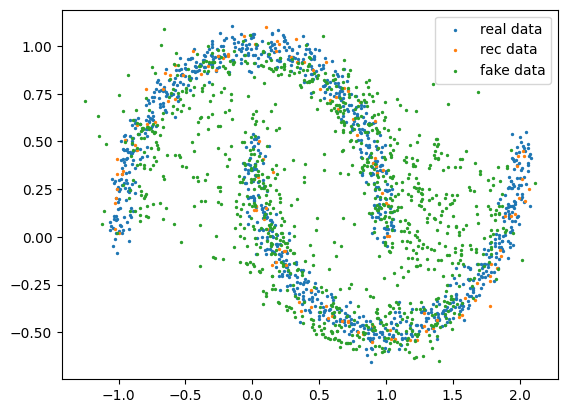

step 8000: KL: 7.502e+00, rec: 4.535e+00


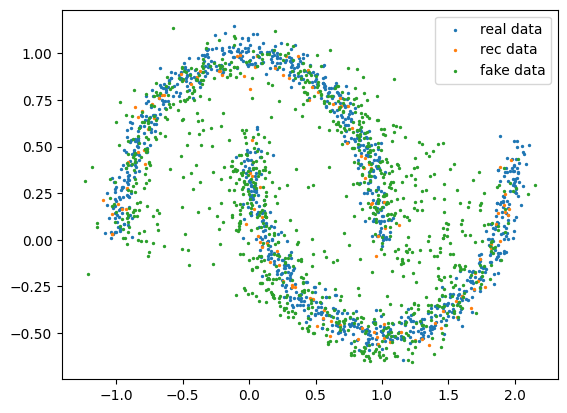

step 9000: KL: 7.506e+00, rec: -2.908e-01


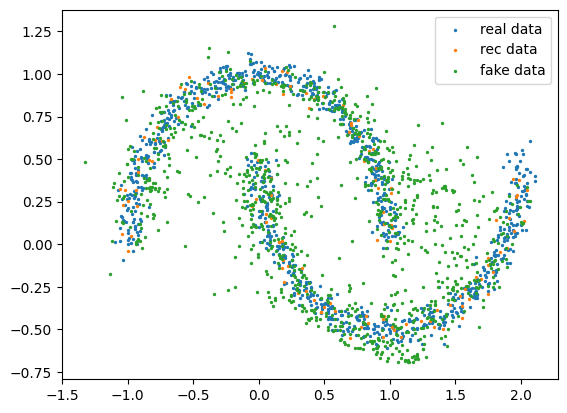

step 10000: KL: 7.478e+00, rec: -4.879e+00


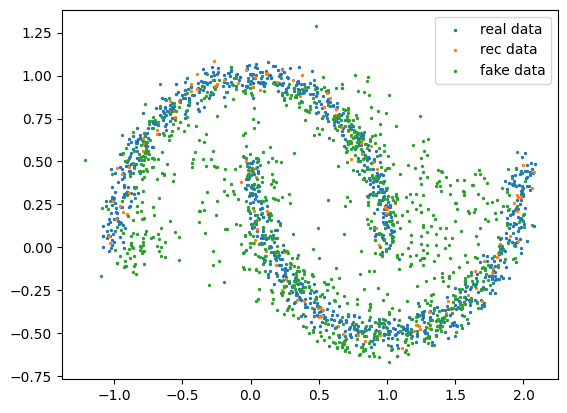

step 11000: KL: 7.505e+00, rec: 3.205e+00


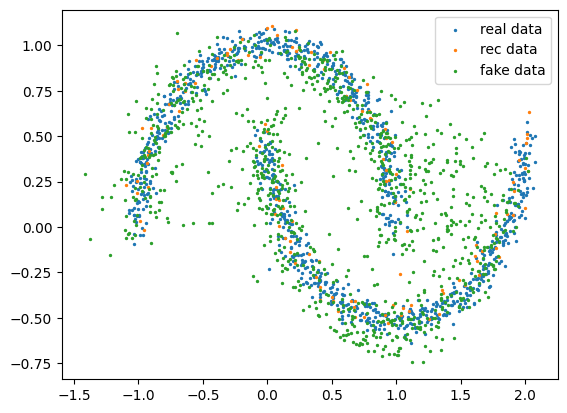

step 12000: KL: 7.451e+00, rec: -7.228e-01


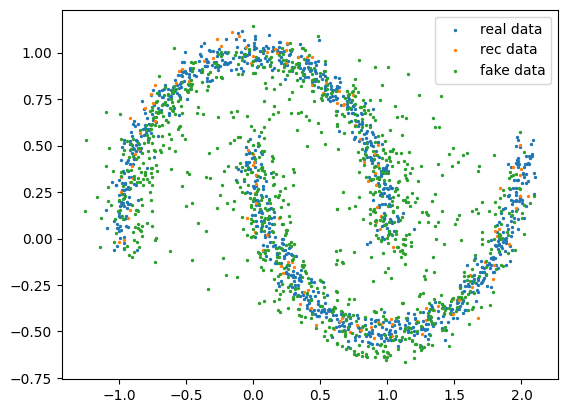

step 13000: KL: 7.481e+00, rec: -4.084e+00


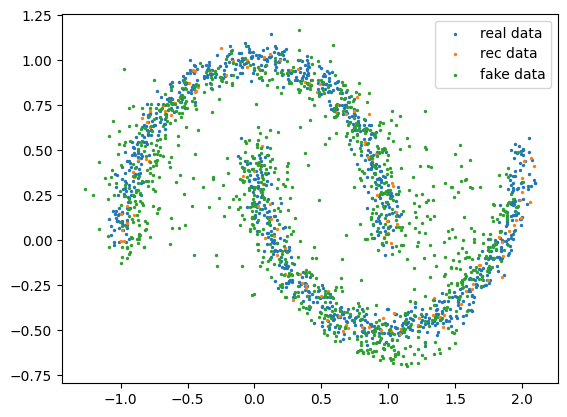

step 14000: KL: 7.393e+00, rec: 1.416e+00


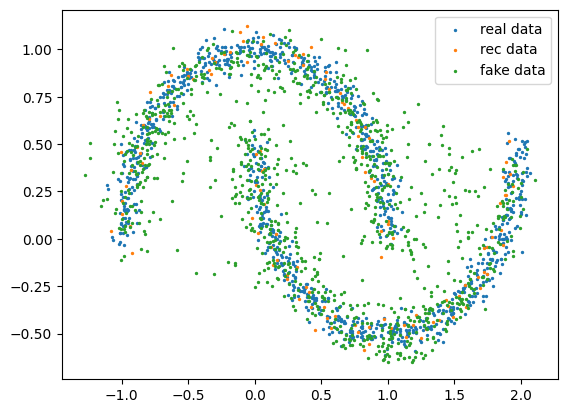

step 15000: KL: 7.271e+00, rec: -3.185e+00


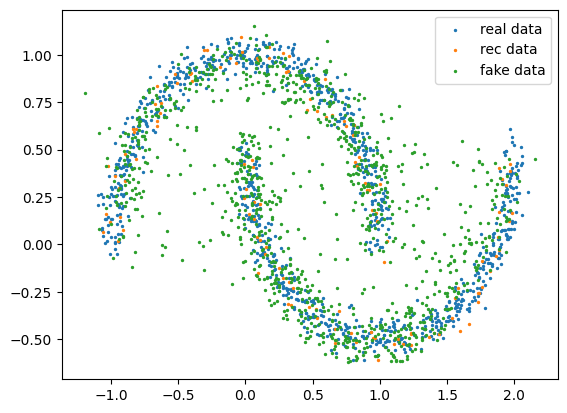

step 16000: KL: 7.402e+00, rec: -4.069e+00


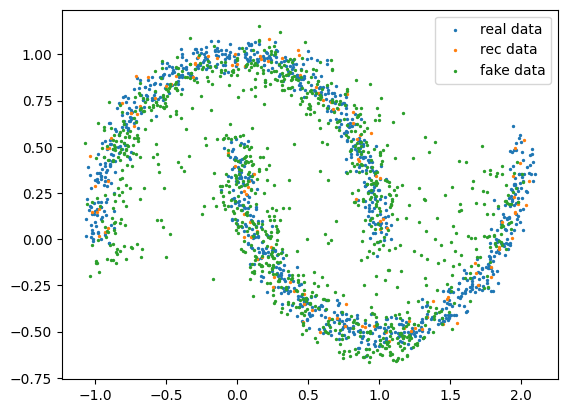

step 17000: KL: 7.380e+00, rec: -3.501e+00


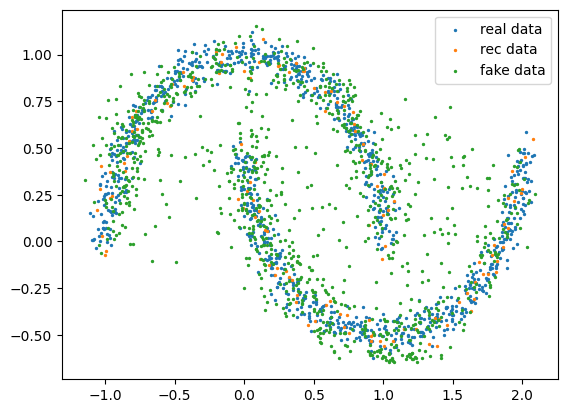

step 18000: KL: 7.242e+00, rec: -4.527e+00


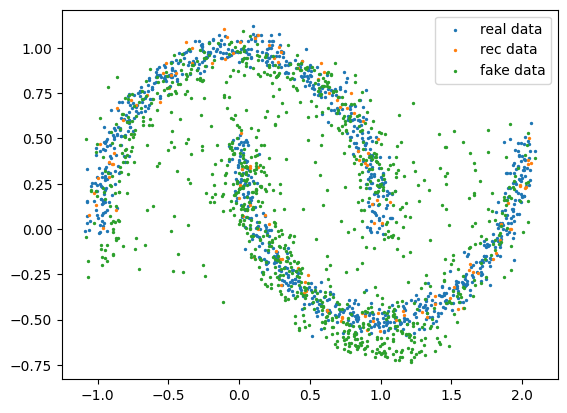

step 19000: KL: 7.367e+00, rec: -4.411e+00


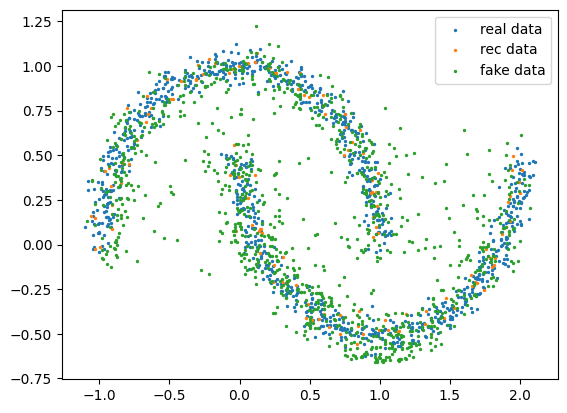

step 20000: KL: 7.464e+00, rec: 1.711e+00


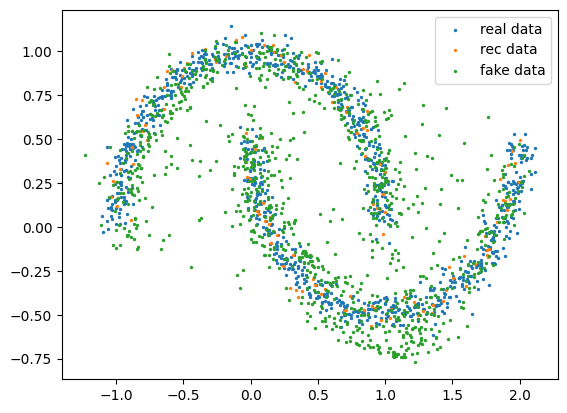

step 21000: KL: 7.264e+00, rec: -5.475e+00


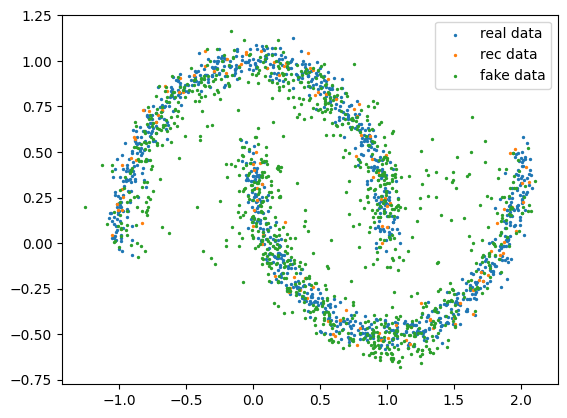

step 22000: KL: 7.489e+00, rec: -3.051e+00


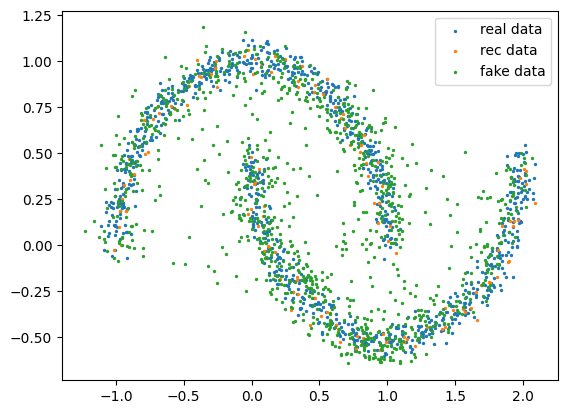

step 23000: KL: 7.239e+00, rec: -4.591e+00


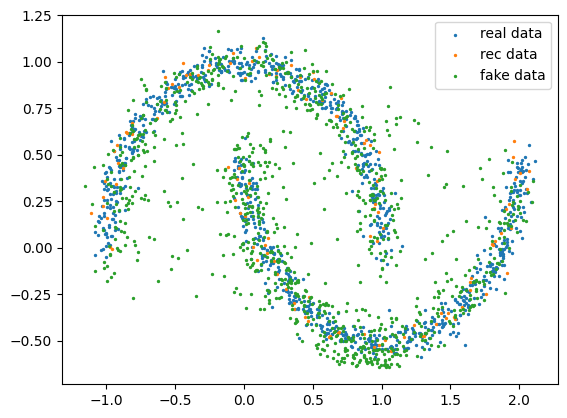

step 24000: KL: 7.299e+00, rec: -5.653e+00


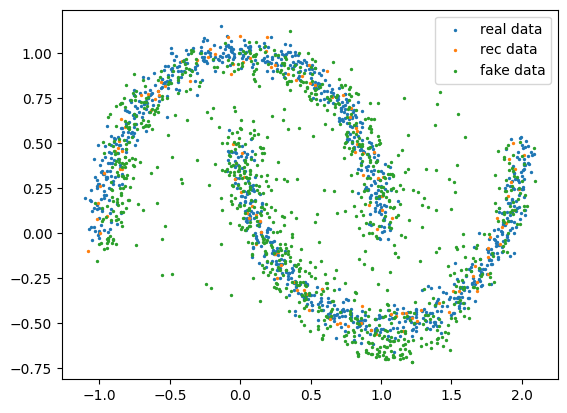

step 25000: KL: 7.525e+00, rec: -1.228e+00


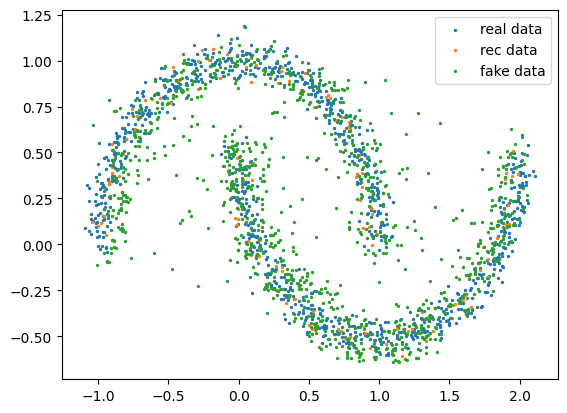

step 26000: KL: 7.381e+00, rec: -5.703e+00


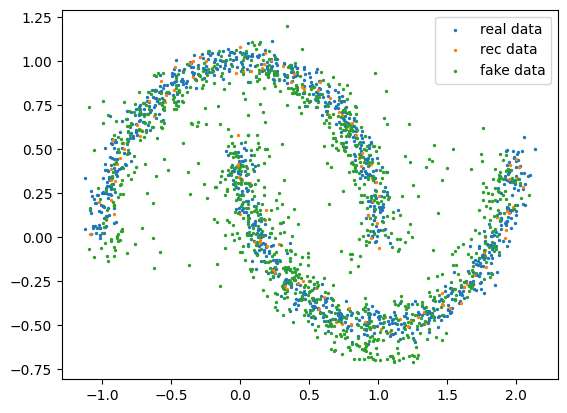

step 27000: KL: 7.170e+00, rec: -2.382e+00


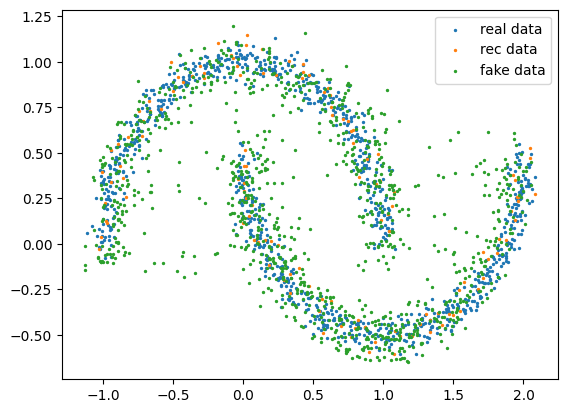

step 28000: KL: 7.457e+00, rec: -2.357e+00


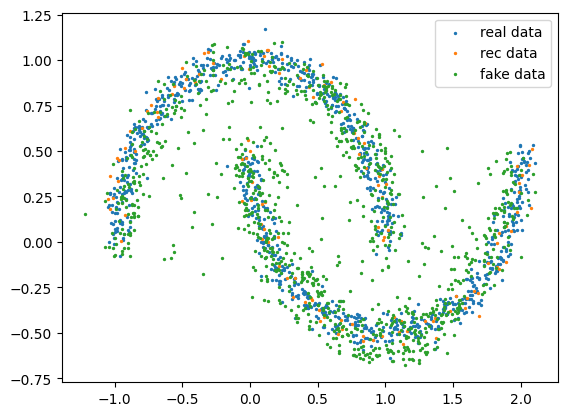

step 29000: KL: 7.370e+00, rec: -4.840e+00


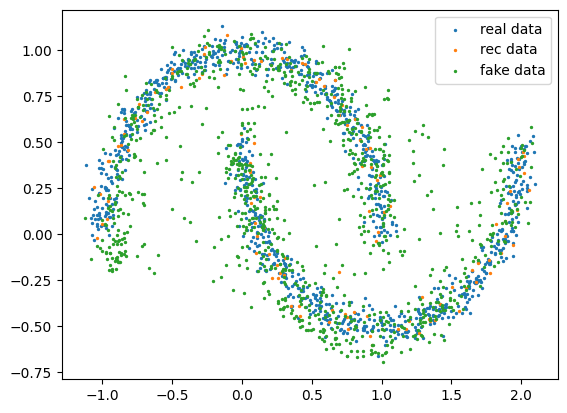

step 30000: KL: 7.315e+00, rec: -5.522e+00


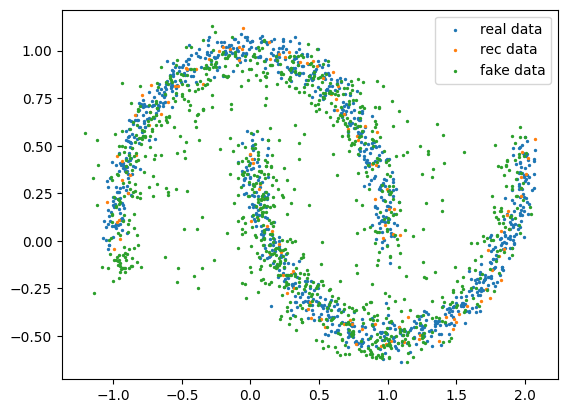

step 31000: KL: 7.342e+00, rec: -5.276e+00


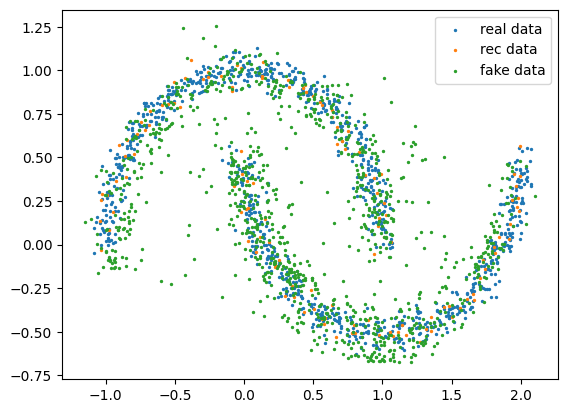

In [ ]:
# Total number of training iterations for the VAE
N_ITER = 40001
# Batch size to use
BATCHLEN = 128

# depth and with of encoder and decoder
depth_encoder, width_encoder = 5, 128
depth_decoder, width_decoder = 5, 128
# flag_hardcoding : true for hardencoding, false otherwise
flag_hardcoding, std = True, 0.0001

encoder = Encoder(depth_encoder, width_encoder)
optim_enc = torch.optim.Adam(encoder.parameters(), lr=0.001, betas=(0.5,0.9))
decoder = Decoder(depth_decoder, width_decoder, flag_hardcoding, std)
optim_dec = torch.optim.Adam(decoder.parameters(), lr=0.001, betas=(0.5,0.9))

start_time = time.time()

for i in range(N_ITER):
    encoder.zero_grad()
    decoder.zero_grad()
    
    x = generate_batch(BATCHLEN)
    
    enc_mu, enc_logvar = encoder(x)
    #
    # COMPUTE THE KL PART OF THE LOSS HERE
    #
    # It corresponds to the formula of Question 10
    # Sum over axis=1 since dimensions are [batch size, 10]
    # Then average losses over batches (over axis 0)
    loss_kl = - LATENT_N/2 + torch.sum(enc_mu**2 + torch.exp(enc_logvar) - enc_logvar, axis=1) / 2
    loss_kl = loss_kl.mean()

    #
    # SAMPLE z FROM q(z|x) HERE
    #
    eps_z = torch.randn((BATCHLEN, LATENT_N))
    z = enc_mu + eps_z*torch.exp(enc_logvar/2) 
    
    dec_mu, dec_logvar = decoder(z)
    #
    # COMPUTE THE RECONSTRUCTION PART OF THE LOSS HERE
    #
    # Start by computing log_p from question 11 
    loss_rec = torch.mean( ( dec_mu.shape[1]*np.log(2*np.pi) + torch.sum(dec_logvar + ((x - dec_mu)**2) * torch.exp(-dec_logvar), dim=1) )/2 )
    
    (loss_kl + loss_rec).backward()
    optim_enc.step()
    optim_dec.step()
    if i%1000 == 0:
        print('step {}: KL: {:.3e}, rec: {:.3e}'.format(i, float(loss_kl), float(loss_rec)))
        # plot the result
        real_batch = generate_batch(1024)
        rec_batch = torch.normal(dec_mu, torch.exp(0.5*dec_logvar)).detach()
        fake_batch = decoder.generate(1024).detach()
        plt.scatter(real_batch[:,0], real_batch[:,1], s=2.0, label='real data')
        plt.scatter(rec_batch[:,0], rec_batch[:,1], s=2.0, label='rec data')
        plt.scatter(fake_batch[:,0], fake_batch[:,1], s=2.0, label='fake data')
        plt.legend()
        plt.show()

execution_time = time.time() - start_time
print(f'Execution time : {execution_time:.2f}s !')

**Q13: How do the power of encoder and decoder affect the overall training of the VAE?**

> **Answer Q13:**

**Power of encoder:** For the VAE, the objective of the encoder is to learn how to project the data into a latent space with "sufficiently interesting features" so that the decoder is able to reconstruct the data efficiently. In our case, the architecture chosen for the encoder has a strong impact on the quality of the results. When the depth of the network is low (no hidden layers or only 1 or 2) then the reconstructions obtained are not as satisfactory as with a deeper network (4, 5 hidden layers wider). Logically, execution times increase with the complexity of the model. It is important to note that it is also necessary to work on the architecture of the decoder in parallel to improve the whole. 

**Power of decoder:** For VAE, the objective of the decoder is to learn to reconstruct the observed data from a latent space. The quality of the representations in the latent space is important for the decoder to work, but it is also important to choose an architecture that allows a good reconstruction. In our case, I have chosen the same architecture as the encoder at the level of the hidden layers and the observations are the same: when the model is deeper and wider, it allows for better reconstructions.

### Normalizing flows

Another approach to generative modelling is given by Normalizing flows. The idea is to learn a mapping $f$ from the data distribution $p_D$ (defined over a space $\mathcal{X}$) to a known distribution (typically, a normal distribution) from which we know how to sample. Two key points are to be noted:
1. The mapping needs to be bijective (i.e., the network needs to be invertible).
2. The exact likelihood of a data point should be easily computable.

To tackle point 2, let us introduce some notations.
Let us denote by $p_\mathcal{N} = \mathcal{N}(0,1)$ the normal distribution from which we sample $z$. We obtain points $x$ by computing $x = f^{-1}(z)$, and we hope that the distribution of points obtained this way will match more or less the dataset distribution $p_D$ of real examples.
We denote by $p_G$ this obtained distribution, that is, the image of $p_\mathcal{N}$ through $f^{-1}$: $p_G$ is a probability distribution defined on $\mathcal{X}$, and our goal will be to optimize the mapping $f$ so that $p_G$ is close to $p_D$. If you are not familiar with images of distributions, the definition is here: https://en.wikipedia.org/wiki/Pushforward_measure ; it can be defined as the measure that satisfies this change of variables: $\int_{z\sim p_\mathcal{N}} g(f^{-1}(z)) dz = \int_{x\sim p_{G}} g(x) dx$ for all functions $g$. Another notation for this is $\int_{z} g(f^{-1}(z)) \;dp_\mathcal{N}(z) = \int_{x} g(x) \;dp_{G}(x)$. 
We will build on the following identity:
$$
\log(p_X(x))=\log(p_Z(z))+\log \det J_f
$$
where $J_f = \frac{df(x)}{dx}$ is the Jacobian matrix of the function $f$.

**Q14: Justify the above equality**

> **Answer Q14:** It's needed to show that :

$$\log(p_X(x))=\log(p_Z(z))+\log \det J_f$$

To start, it is known that :

$$\int_{z\sim p_\mathcal{N}} g(f^{-1}(z)) dz = \int_{x\sim p_{G}} g(x) dx$$

Since $J_f = \frac{df(x)}{dx}$, it comes that :

$$\int_{z\sim p_\mathcal{N}} g(f^{-1}(z)) dz = \int_{z\sim p_\mathcal{N}} g(z) \frac{df(x)}{dx} dz = \int_{z\sim p_\mathcal{N}} g(z) |J_f| dz$$

Hence :

$$\int_{x\sim p_{G}} g(x) dx = \int_{z\sim p_\mathcal{N}} g(z) |J_f| dz$$

So finally, it comes that :

$$p_X(x)=p_Z(z) |J_f|$$

$$\Longrightarrow \log(p_X(x))=\log(p_Z(z))+\log \det J_f$$

Let us consider, as an optimization criterion, the Kullback-Leibler divergence $KL(p_D||p_G)$.

**Q15: Express this loss as a (very simple) function of the quantity above.**

> **Answer Q15:** It comes that:

$$KL(p_D||p_G) = \mathbb{E}_{p_D}\left[ log(\frac{p_D}{p_G}) \right] = \mathbb{E}_{p_D}\left[ log(p_D) - log(p_G) \right] = \mathbb{E}_{p_D}\left[ log(p_D) - \log(p_Z(z)) - \log \det J_f \right]$$

As $log(p_D)$ is independant from $P_G$, it comes that the Loss can be written : 

$$Loss = -  \mathbb{E}_{p_D}\left[ \log(p_Z(z)) + \log \det J_f \right]$$

A challenging task is then to find a network, such that f is:
* invertible
* $\det J_f$ is tractable
* $f$ is general enough

A common architecture is the so called real-valued non-volume preserving (real-NVP), which is made of coupling layers.

The idea of coupling layers is to cut the input $x$ in two (let say keeping only the $d < D$ first dimensions on one hand and the $D-d$ other dimensions on the other hand, with $D$ the dimension of the input space $\mathcal{X}$). This gives inputs $x_{1:d}$ and $x_{d+1:D}$. Then the forward pass is defined as:
* $y_{1:d}=x_{1:d}$
* $y_{d+1:D}=x_{d+1:D}\odot \exp(s(x_{1:d})) + t(x_{1:d})$

where $s,t:\mathbb{R}^d\to\mathbb{R}^{D-d}$ and $\odot$ is the coefficient-wise multiplication of two vectors of the same size.

Those equations can be resumed in the following diagram:
![real NVP diagram](realNVPforward.png)

**Q16: Show that the defined mapping is indeed invertible**

> **Answer Q16:**

For the first part, it is obvious that $

$$y_{1:d}=x_{1:d} \Longleftrightarrow x_{1:d}=y_{1:d}$$

For the second part, it comes that :

$$y_{d+1:D}=x_{d+1:D}\odot \exp(s(x_{1:d})) + t(x_{1:d})$$

$$\Longleftrightarrow y_{d+1:D} - t(x_{1:d}) = x_{d+1:D}\odot \exp(s(x_{1:d}))$$

$$\Longleftrightarrow (y_{d+1:D} - t(x_{1:d})) \odot \exp(-s(x_{1:d}))= x_{d+1:D}\odot \exp(s(x_{1:d})) \odot \exp(-s(x_{1:d})) = x_{d+1:D}$$

Hence it is indeed invertible.

**Q17: Show that the determinant of the Jacobian of such a mapping is $\exp(\sum_j s(x_{1:d})_j)$**

> **Answer Q17:** 

As it was defined previously and with previous explanations, it comes that :

$$J_f = \frac{df(x)}{dx} = 
\begin{pmatrix}
\frac{d y_{1:d}} {d x_{1:d}}  &  \frac{d y_{1:d}}{d x_{d+1:D}}  \\
\frac{d y_{d+1:D}}{d x_{1:d}}  &  \frac{d y_{d+1:D}}{d x_{d+1:D}}  
\end{pmatrix}$$

For $\frac{d y_{1:d}} {d x_{1:d}}$, it can be seen that :

$$ \forall i \in \{1, 2.., d\} : \frac{dy_i}{dx_i} = 1 \mbox{ if } i=j, 0 \mbox{ otherwise.}$$

The same way for $\frac{d y_{1:d}}{d x_{d+1:D}}$, it comes that :

$$\forall i \in \{d+1, d+2.., D\} : \frac{dy_i}{dx_i} = 0$$

Finally for $\frac{d y_{d+1:D}}{d x_{d+1:D}}$, it comes that :

$$\forall i \in \{d+1, d+2.., D\} : \frac{dy_i}{dx_i} = Diag(exp(s(x_{i})) $$

For the Jacobian matrix, it comes that : 

$$J_f = \frac{df(x)}{dx} = 
\begin{pmatrix}
1_d  &  0  \\
\frac{d y_{d+1:D}}{d x_{1:d}}  &  Diag(exp(s(x_{1:d}))  
\end{pmatrix} \Longrightarrow |J_f| = \prod_{i=1}^{d} exp(s(x_{1:d})_{i}) = exp(\sum_{i=1}^{d} s(x_{1:d})_{i})$$

**Q18: Fill the Coupling layer structure below by defining suitable functions sfun and tfun (using a final tanh in sfun is highly recommended) and the inverse pass**

In [35]:
import torch
from torch import nn
from torch.nn import functional as F


class CouplingLayer(nn.Module):
    def __init__(self, input_size, output_size, hidden_size, mask):
        super().__init__()
        ### define here variables to use in f and s ###
        # layer for s function
        self.sfun_layers_list = [nn.Linear(input_size, hidden_size), torch.nn.ReLU(inplace = True),
                                nn.Linear(hidden_size, hidden_size), torch.nn.ReLU(inplace = True), 
                                nn.Linear(hidden_size,output_size), torch.nn.Tanh()]
        self.sfun_layers = nn.Sequential(*self.sfun_layers_list)
        # layer for t function
        self.tfun_layers_list = [nn.Linear(input_size, hidden_size), torch.nn.ReLU(inplace = True),
                                nn.Linear(hidden_size, hidden_size), torch.nn.ReLU(inplace = True), 
                                nn.Linear(hidden_size,output_size)]
        self.tfun_layers = nn.Sequential(*self.tfun_layers_list)

        self.mask = mask #we use the mask variable to make the cut in input

    def sfun(self, x_m):
        x_m = self.sfun_layers(x_m)
        return x_m
        
    def tfun(self, x_m):
        x_m = self.tfun_layers(x_m)
        return x_m
        
    def forward(self, x):
        x_m = x * self.mask
        s_out = self.sfun(x_m) # multiplicative block
        t_out = self.tfun(x_m) # additive block
        y = x_m + (1-self.mask)*(x*torch.exp(s_out)+t_out)
        log_det_jacobian = s_out.sum(dim=1)  # CRITICAL
        return y, log_det_jacobian

    def inverse(self, y):
        # first step is to apply mask
        y_masked = self.mask*y
        # apply f and s funs on y_masked 
        y_masked_tfun = self.tfun(y_masked)
        y_masked_sfun = self.sfun(y_masked)
        # inverse
        y_masked += ((1 - self.mask)*y - y_masked_tfun) * torch.exp(-y_masked_sfun)
        return y_masked

In [36]:
class RealNVP(nn.Module):
    def __init__(self, input_size, output_size, hidden_size, mask, n_layers=6):
        super().__init__()
        assert n_layers >= 2, "num of coupling layers should be greater or equal to 2"

        self.modules = []
        self.modules.append(CouplingLayer(input_size, output_size, hidden_size, mask))
        for _ in range(n_layers-2):
            mask = 1 - mask
            self.modules.append(CouplingLayer(input_size, output_size, hidden_size, mask))
        self.modules.append(CouplingLayer(input_size, output_size, hidden_size, 1 - mask))
        self.module_list = nn.ModuleList(self.modules)

    def forward(self, x):
        ldj_sum = 0  # sum of log determinant of jacobian
        for module in self.module_list:
            x, ldj = module(x)
            ldj_sum += ldj
        return x, ldj_sum

    def inverse(self, z):
        for module in reversed(self.module_list):
            z = module.inverse(z)
        return z

In [37]:
import os

import matplotlib.pyplot as plt
import numpy as np
import torch


def train(epoch, model, optimizer, prior_z, train_loader, log_interval=50):
    model.train()
    train_loss = 0
    for batch_idx, x_inputs in enumerate(train_loader):
        optimizer.zero_grad()
        z_outputs, log_det_j_sum = model.forward(x_inputs)  # train with the forward
        loss = -(prior_z.log_prob(z_outputs)+log_det_j_sum).mean()  # CRITICAL
        loss.backward()
        cur_loss = loss.item()
        train_loss += cur_loss
        optimizer.step()
        if batch_idx % log_interval == 0:
            print("Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}".format(
                epoch, batch_idx * len(x_inputs), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), cur_loss / len(x_inputs)))

    average_train_loss = train_loss / len(train_loader.dataset)
    print(f"====> Epoch: {epoch} Average train loss: {average_train_loss:.4f}")


def test(epoch, model, prior_z, test_loader):
    model.eval()
    test_loss = 0
    x_all = np.array([[]]).reshape(0, 2)
    z_all = np.array([[]]).reshape(0, 2)
    with torch.no_grad():
        for batch_idx, x_inputs in enumerate(test_loader):
            z_outputs, log_det_j_sum = model.forward(x_inputs)
            cur_loss = -(prior_z.log_prob(z_outputs)+log_det_j_sum).mean().item()
            test_loss += cur_loss
            x_all = np.concatenate((x_all, x_inputs.numpy()))
            z_all = np.concatenate((z_all, z_outputs.numpy()))

        subfig_plot(1, x_all, -2, 3, -1, 1.5, "Input: x ~ p(x)", "b")
        subfig_plot(2, z_all, -3, 3, -3, 3, "Output: z = f(x)", "b")

        test_loss /= len(test_loader.dataset)
        print(f"====> Test loss: {test_loss:.4f}")


def sample(epoch, model, prior_z, save_plt_interval=5):
    model.eval()
    with torch.no_grad():
        z_inputs = prior_z.sample((1000,))
        x_outputs = model.inverse(z_inputs)  # generation with the inverse
        z_inputs = z_inputs.numpy()
        x_outputs = x_outputs.numpy()

        subfig_plot(3, z_inputs, -3, 3, -3, 3, "Input: z ~ p(z)", "r")
        subfig_plot(4, x_outputs, -2, 3, -1, 1.5, "Output: x = g(z) (g: inverse of f)", "r")

        if epoch % save_plt_interval == 0:
            if not os.path.exists("results"):
                os.makedirs("results")
            plt.savefig("results/"+"result_"+str(epoch)+".png")


def subfig_plot(location, data, x_start, x_end, y_start, y_end, title, color):
    if location == 1:
        plt.clf()
    plt.subplot(2, 2, location)
    plt.scatter(data[:, 0], data[:, 1], c=color, s=1)
    plt.xlim(x_start, x_end)
    plt.ylim(y_start, y_end)
    plt.title(title)
    plt.pause(1e-2)

In [38]:
# globals
BATCH_SIZE = 128
LOG_INTERVAL = 50
N_EPOCHS = 10
INPUT_SIZE = 2
OUTPUT_SIZE = 2
HIDDEN_SIZE = 256
SAVE_PLT_INTERVAL = 5
N_COUPLING_LAYERS = 8

In [39]:
# data loading
train_data = datasets.make_moons(n_samples=50000, noise=.05)[0].astype(np.float32)
test_data = datasets.make_moons(n_samples=1000, noise=.05)[0].astype(np.float32)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
loader_kwargs = {"num_workers": 1, "pin_memory": True} if device == "cuda" else {}
train_loader = torch.utils.data.DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True, **loader_kwargs)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=True, **loader_kwargs)

In [40]:
from torch import distributions # optim, 
# model construction
mask = torch.from_numpy(np.array([0, 1]).astype(np.float32))
model = RealNVP(INPUT_SIZE, OUTPUT_SIZE, HIDDEN_SIZE, mask, N_COUPLING_LAYERS)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
prior_z = distributions.MultivariateNormal(torch.zeros(2), torch.eye(2))

Train Epoch: 1 [0/50000 (0%)]	Loss: 0.017994
Train Epoch: 1 [6400/50000 (13%)]	Loss: -0.038610
Train Epoch: 1 [12800/50000 (26%)]	Loss: -0.048968
Train Epoch: 1 [19200/50000 (38%)]	Loss: -0.052976
Train Epoch: 1 [25600/50000 (51%)]	Loss: -0.052720
Train Epoch: 1 [32000/50000 (64%)]	Loss: -0.054647
Train Epoch: 1 [38400/50000 (77%)]	Loss: -0.055490
Train Epoch: 1 [44800/50000 (90%)]	Loss: -0.055221
====> Epoch: 1 Average train loss: -0.0481


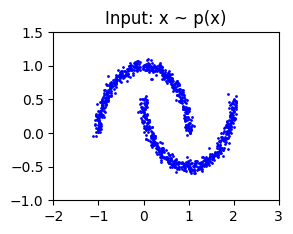

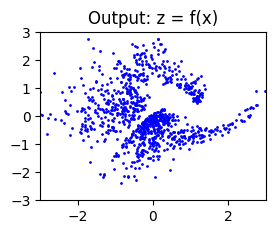

====> Test loss: -0.0573


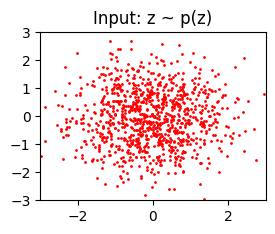

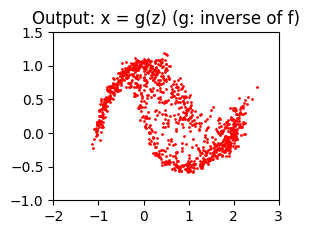

Train Epoch: 2 [0/50000 (0%)]	Loss: -0.055646
Train Epoch: 2 [6400/50000 (13%)]	Loss: -0.051500
Train Epoch: 2 [12800/50000 (26%)]	Loss: -0.054994
Train Epoch: 2 [19200/50000 (38%)]	Loss: -0.055177
Train Epoch: 2 [25600/50000 (51%)]	Loss: -0.055639
Train Epoch: 2 [32000/50000 (64%)]	Loss: -0.056033
Train Epoch: 2 [38400/50000 (77%)]	Loss: -0.058124
Train Epoch: 2 [44800/50000 (90%)]	Loss: -0.057791
====> Epoch: 2 Average train loss: -0.0557


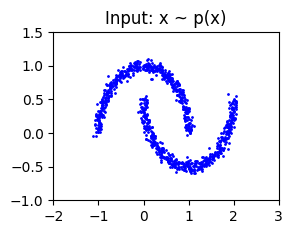

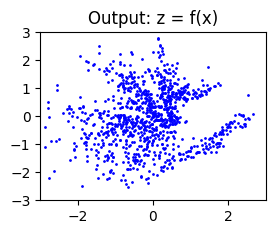

====> Test loss: -0.0588


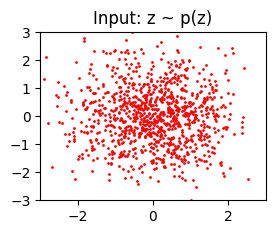

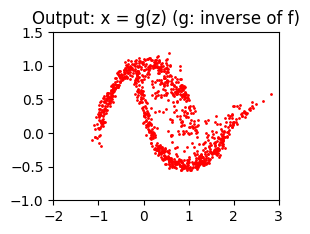

Train Epoch: 3 [0/50000 (0%)]	Loss: -0.056853
Train Epoch: 3 [6400/50000 (13%)]	Loss: -0.056605
Train Epoch: 3 [12800/50000 (26%)]	Loss: -0.058981
Train Epoch: 3 [19200/50000 (38%)]	Loss: -0.058106
Train Epoch: 3 [25600/50000 (51%)]	Loss: -0.058266
Train Epoch: 3 [32000/50000 (64%)]	Loss: -0.058251
Train Epoch: 3 [38400/50000 (77%)]	Loss: -0.058523
Train Epoch: 3 [44800/50000 (90%)]	Loss: -0.057774
====> Epoch: 3 Average train loss: -0.0580


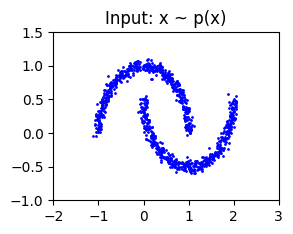

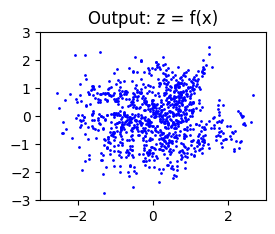

====> Test loss: -0.0602


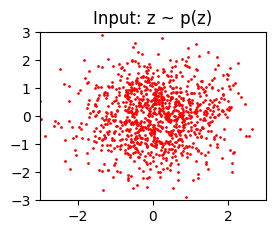

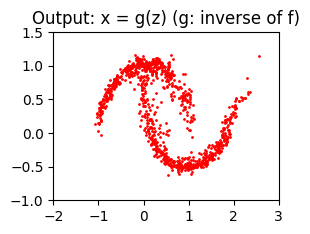

Train Epoch: 4 [0/50000 (0%)]	Loss: -0.058926
Train Epoch: 4 [6400/50000 (13%)]	Loss: -0.059643
Train Epoch: 4 [12800/50000 (26%)]	Loss: -0.058814
Train Epoch: 4 [19200/50000 (38%)]	Loss: -0.059183
Train Epoch: 4 [25600/50000 (51%)]	Loss: -0.059399
Train Epoch: 4 [32000/50000 (64%)]	Loss: -0.058342
Train Epoch: 4 [38400/50000 (77%)]	Loss: -0.059328
Train Epoch: 4 [44800/50000 (90%)]	Loss: -0.060155
====> Epoch: 4 Average train loss: -0.0588


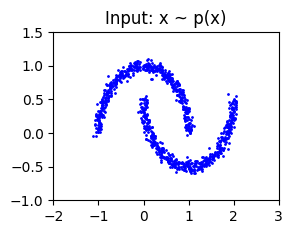

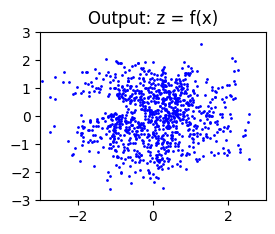

====> Test loss: -0.0606


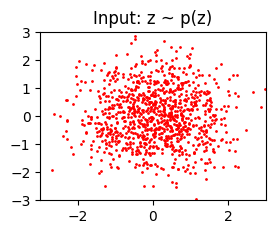

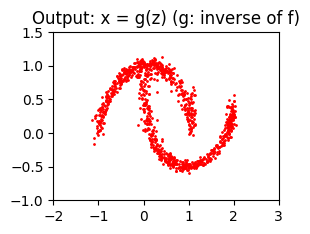

Train Epoch: 5 [0/50000 (0%)]	Loss: -0.059579
Train Epoch: 5 [6400/50000 (13%)]	Loss: -0.059909
Train Epoch: 5 [12800/50000 (26%)]	Loss: -0.058849
Train Epoch: 5 [19200/50000 (38%)]	Loss: -0.058411
Train Epoch: 5 [25600/50000 (51%)]	Loss: -0.060063
Train Epoch: 5 [32000/50000 (64%)]	Loss: -0.059448
Train Epoch: 5 [38400/50000 (77%)]	Loss: -0.059358
Train Epoch: 5 [44800/50000 (90%)]	Loss: -0.060456
====> Epoch: 5 Average train loss: -0.0592


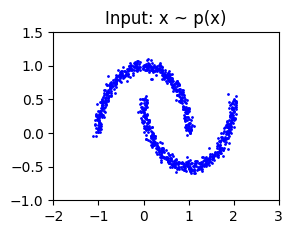

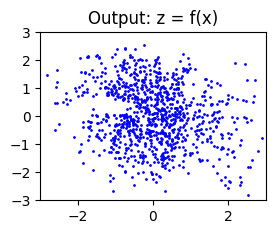

====> Test loss: -0.0604


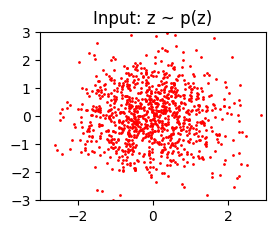

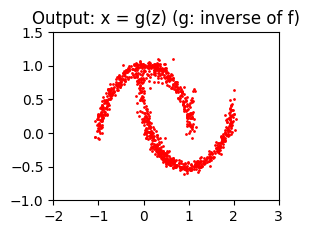

Train Epoch: 6 [0/50000 (0%)]	Loss: -0.058698
Train Epoch: 6 [6400/50000 (13%)]	Loss: -0.059011
Train Epoch: 6 [12800/50000 (26%)]	Loss: -0.059654
Train Epoch: 6 [19200/50000 (38%)]	Loss: -0.059579
Train Epoch: 6 [25600/50000 (51%)]	Loss: -0.059296
Train Epoch: 6 [32000/50000 (64%)]	Loss: -0.059156
Train Epoch: 6 [38400/50000 (77%)]	Loss: -0.059433
Train Epoch: 6 [44800/50000 (90%)]	Loss: -0.059099
====> Epoch: 6 Average train loss: -0.0593


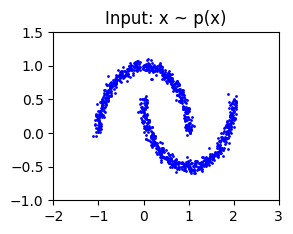

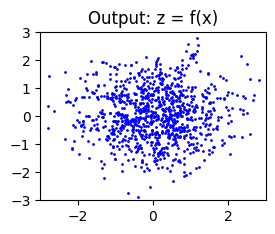

====> Test loss: -0.0610


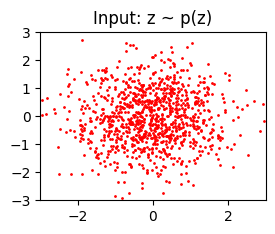

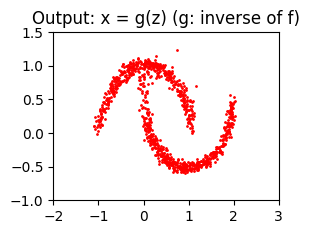

Train Epoch: 7 [0/50000 (0%)]	Loss: -0.059891
Train Epoch: 7 [6400/50000 (13%)]	Loss: -0.059690
Train Epoch: 7 [12800/50000 (26%)]	Loss: -0.058717
Train Epoch: 7 [19200/50000 (38%)]	Loss: -0.059058
Train Epoch: 7 [25600/50000 (51%)]	Loss: -0.059403
Train Epoch: 7 [32000/50000 (64%)]	Loss: -0.060179
Train Epoch: 7 [38400/50000 (77%)]	Loss: -0.059738
Train Epoch: 7 [44800/50000 (90%)]	Loss: -0.059219
====> Epoch: 7 Average train loss: -0.0595


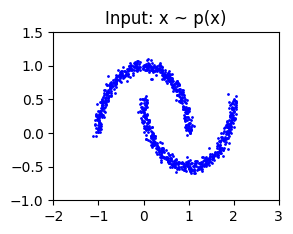

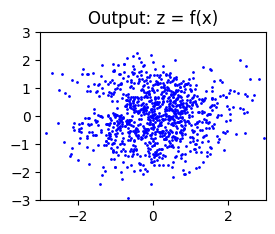

====> Test loss: -0.0610


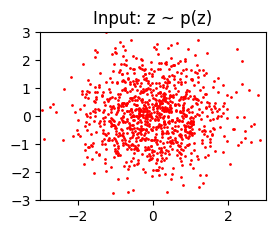

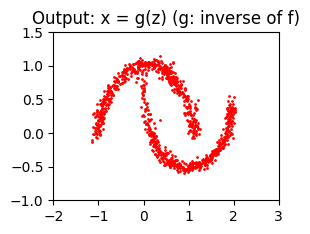

Train Epoch: 8 [0/50000 (0%)]	Loss: -0.058701
Train Epoch: 8 [6400/50000 (13%)]	Loss: -0.059947
Train Epoch: 8 [12800/50000 (26%)]	Loss: -0.059374
Train Epoch: 8 [19200/50000 (38%)]	Loss: -0.059433
Train Epoch: 8 [25600/50000 (51%)]	Loss: -0.059780
Train Epoch: 8 [32000/50000 (64%)]	Loss: -0.060019
Train Epoch: 8 [38400/50000 (77%)]	Loss: -0.060145
Train Epoch: 8 [44800/50000 (90%)]	Loss: -0.059275
====> Epoch: 8 Average train loss: -0.0594


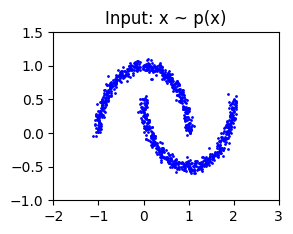

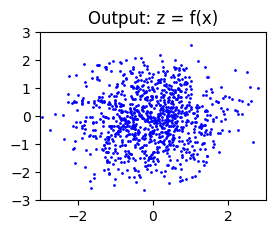

====> Test loss: -0.0612


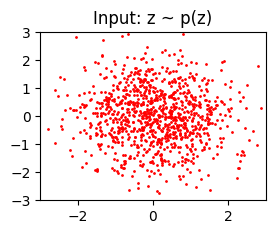

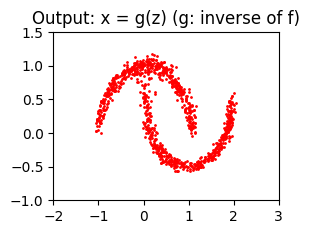

Train Epoch: 9 [0/50000 (0%)]	Loss: -0.060139
Train Epoch: 9 [6400/50000 (13%)]	Loss: -0.058719
Train Epoch: 9 [12800/50000 (26%)]	Loss: -0.059879
Train Epoch: 9 [19200/50000 (38%)]	Loss: -0.058988
Train Epoch: 9 [25600/50000 (51%)]	Loss: -0.060069
Train Epoch: 9 [32000/50000 (64%)]	Loss: -0.059214
Train Epoch: 9 [38400/50000 (77%)]	Loss: -0.059218
Train Epoch: 9 [44800/50000 (90%)]	Loss: -0.058238
====> Epoch: 9 Average train loss: -0.0595


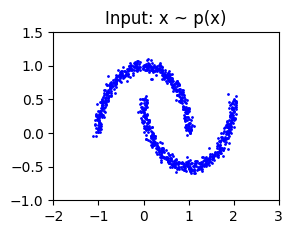

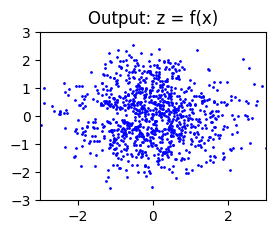

====> Test loss: -0.0611


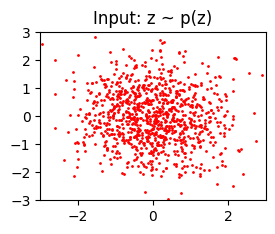

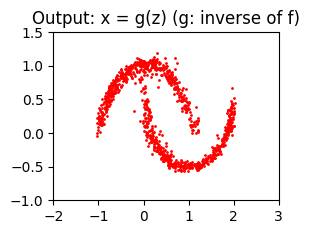

Train Epoch: 10 [0/50000 (0%)]	Loss: -0.059293
Train Epoch: 10 [6400/50000 (13%)]	Loss: -0.059406
Train Epoch: 10 [12800/50000 (26%)]	Loss: -0.059830
Train Epoch: 10 [19200/50000 (38%)]	Loss: -0.059718
Train Epoch: 10 [25600/50000 (51%)]	Loss: -0.059243
Train Epoch: 10 [32000/50000 (64%)]	Loss: -0.060130
Train Epoch: 10 [38400/50000 (77%)]	Loss: -0.060501
Train Epoch: 10 [44800/50000 (90%)]	Loss: -0.059655
====> Epoch: 10 Average train loss: -0.0596


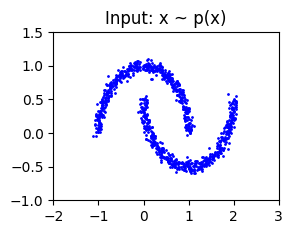

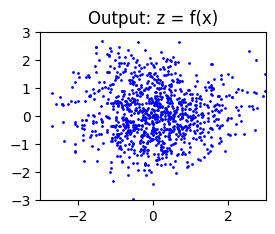

====> Test loss: -0.0611


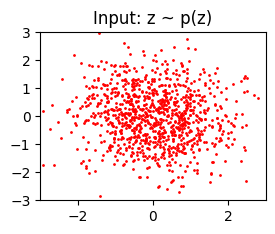

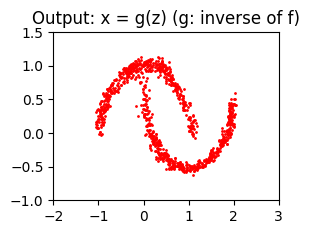

'217.17s'

<Figure size 640x480 with 0 Axes>

In [41]:
from timeit import default_timer as timer
# run
start = timer()
for epoch in range(1, N_EPOCHS + 1):
    train(epoch, model, optimizer, prior_z, train_loader)
    test(epoch, model, prior_z, test_loader)
    sample(epoch, model, prior_z)
f"{timer() - start:.02f}s"

**Q19: Explain why Normalizing flows do not fit well when there are many clusters in data**

> **Answer Q19:** 

If there are several clusters in the data, there are discontinuities in the data distribution.
 However, Normalizing Flows transforms a simple distribution into a more complex distribution that fits the data. Thus, this method models the distribution of the data as a continuous function. As a result, it can be difficult to represent and capture these discontinuities.
 In some ways, this can lead to over/under-fitting as the distribution may well succeed in modelling some clusters but have much more difficulty in modelling others, particularly new data.

### Conclusion

**Q.27: As a conclusion, how would you compare the advantages and shortcomings of GANs, VAEs, Normalizing flows and Denoising Models ?**

> **Answer Q27:** 

**Comments on GANs:** The first part of the tutorial was devoted to GANs. The results obtained are very satisfactory as GANs are able to generate diverse and good quality samples. However, these models can be difficult to train because many details must be taken into account: the generator and the descriminator must be implemented with rigour and attention in order to obtain good results. Thus, these models are sensitive to hyper-parameters and can be time consuming to train. In addition, they are less expressive than VAEs, for example.

**Comments on VAEs:** Indeed, the strong point of VAEs is their expressiveness because they contain a latent space that learns representations of the input data. In addition, the architecture allows the method to be able to generate a wide variety of samples. However, the addition of noise means that the samples generated are not always as accurate as with GANs: VAEs have difficulty capturing some of the details of the data distributions.

**Comments on Normalizing Flows:** Unlike VAEs, no noise is introduced into the NF training, so this method tends to better capture the local variance of the data distribution. As discussed earlier, a shortcoming of NF is that it is not very effective when the distribution has multiple clusters. The model provides good representations, but can be difficult and time-consuming to train as this method is particularly prone to divergence.

# END of DLiP TP6 !

Thank you for reading !